In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/'My Drive'/UniversalEmb

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/UniversalEmb


In [0]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time
import torch
from math import sqrt 
from torchvision import datasets
from torchvision import transforms 

from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
def train_base_MLP(train, test):
  tf = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_df=0.98, min_df=3)
  tf_res = tf.fit_transform(train.text)
  test_transform = tf.transform(test.text)
  tf_res.shape
  class WordData(Dataset):
      
      def __init__(self, x_data, y_data):
          
          super().__init__()
          
          self.x_data = x_data
          self.y_data = torch.LongTensor([int(i) for i in y_data])
          
      
      def __len__(self):
          
          return self.x_data.shape[0]
      
      def __getitem__(self, idx):
          
          x = self.x_data[idx].toarray()
          x = torch.FloatTensor(x)
          y = self.y_data[idx]
          
          return x, y


  dataset_train = WordData(tf_res, train.lbl_index)
  dataset_test = WordData(test_transform, test.lbl_index)

  batch_size = 256

  train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,  shuffle=True)
  validation_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

  class MLP(torch.nn.Module):
      
      def __init__(self, in_features, inner_features, inner_features2, out_features):
          
          # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
          # Вызываем __init__ родителя - torch.nn.Module
          super().__init__()
          
          # определяем слои и все что захотим сохранять/использовать
          self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
          gl = sqrt(6./(in_features+inner_features))
          self.linear_1.weight.data.uniform_(-gl, gl)
          self.non_linear_function = torch.nn.ReLU()
          self.drop_out = torch.nn.Dropout(0.18)
          self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=inner_features2)
          gl1 = sqrt(6./(inner_features+inner_features2))
          self.linear_2.weight.data.uniform_(-gl1, gl1)
          self.non_linear_function2 = torch.nn.ReLU()
          self.linear_3 = torch.nn.Linear(in_features=inner_features2, out_features=out_features)
          gl2 = sqrt(6./(inner_features2+out_features))
          self.linear_3.weight.data.uniform_(-gl2, gl2)
    
      def forward(self, x):
          
          # наша привычная схема
          x = self.linear_1(x)
          x = self.non_linear_function(x)
          x = self.drop_out(x)
          x = self.linear_2(x)
          x = self.non_linear_function2(x)
          x = self.linear_3(x)
          
          return x
  model = MLP(in_features=tf_res.shape[1], inner_features=524, inner_features2=256, out_features=len(set(train.lbl_index)))
  optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005,  betas=(0.9, 0.999) )
  # aka loss function
  criterion = torch.nn.CrossEntropyLoss()
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model = model.to(device)

  epochs = 35
  losses = []
  best_test_loss = 10.

  test_f1 = []

  for n_epoch in range(epochs):
      
      train_losses = []
      test_losses = []
      test_targets = []
      test_pred_class = []
      
      progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
      
      model.train()
      
      for x, y in train_loader:
          x = x.to(device)
          y = y.to(device)

          optimizer.zero_grad()

          pred = model(x).squeeze(1)
          loss = criterion(pred, y)
          
          loss.backward()
          
          optimizer.step()
          
          train_losses.append(loss.item())
          losses.append(loss.item())
          
          progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

          progress_bar.update(x.shape[0])
          
      progress_bar.close()
      
      model.eval()
      
      for x, y in validation_loader:     
          
          x = x.to(device)
          y = y.to(device)
        

          with torch.no_grad():
              pred = model(x).squeeze(1)

              pred = pred.cpu()
              y = y.cpu()

              test_targets.append(y.numpy())
              test_pred_class.append(np.argmax(pred, axis=1))

              loss = criterion(pred, y)

              test_losses.append(loss.item())
          
      mean_test_loss = np.mean(test_losses)

      test_targets = np.concatenate(test_targets).squeeze()
      test_pred_class = np.concatenate(test_pred_class).squeeze()

      f1 = f1_score(test_targets, test_pred_class, average='weighted')
      acc = accuracy_score(test_targets, test_pred_class)

      test_f1.append(f1)
      
      print()
      print('Losses: train - {:.7f}, test - {:.7f}'.format(np.mean(train_losses), mean_test_loss))

      print('F1 test - {:.4f}'.format(f1))
      print('ACC test - {:.4f}'.format(acc))
          
      # Early stopping:
      if mean_test_loss < best_test_loss:
          best_test_loss = mean_test_loss
      else:
          print('Early stopping')
          break
  print()
  print()
  return f1, acc

In [0]:
def re_FIT_base_MLP(train, test, model=None, tf=None, epochs=1, batch_size = 256, out_feat=None):
  if out_feat is None:
    out_feat = len(set(train.lbl_index))
  if tf is None:
    tf = TfidfVectorizer(lowercase = False, ngram_range = (1,3), max_df=0.98, min_df=3)
    tf_res = tf.fit_transform(train.text)
  else:
    tf_res = tf.transform(train.text)
  test_transform = tf.transform(test.text)
  tf_res.shape
  class WordData(Dataset):
      
      def __init__(self, x_data, y_data):
          
          super().__init__()
          
          self.x_data = x_data
          self.y_data = torch.LongTensor([int(i) for i in y_data])
          
      
      def __len__(self):
          
          return self.x_data.shape[0]
      
      def __getitem__(self, idx):
          
          x = self.x_data[idx].toarray()
          x = torch.FloatTensor(x)
          y = self.y_data[idx]
          
          return x, y


  dataset_train = WordData(tf_res, train.lbl_index)
  dataset_test = WordData(test_transform, test.lbl_index)

  train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,  shuffle=True)
  validation_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

  class MLP(torch.nn.Module):
      
      def __init__(self, in_features, inner_features, inner_features2, out_features):
          
          # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
          # Вызываем __init__ родителя - torch.nn.Module
          super().__init__()
          
          # определяем слои и все что захотим сохранять/использовать
          self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
          gl = sqrt(6./(in_features+inner_features))
          self.linear_1.weight.data.uniform_(-gl, gl)
          self.non_linear_function = torch.nn.ReLU()
          self.drop_out = torch.nn.Dropout(0.18)
          self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=inner_features2)
          gl1 = sqrt(6./(inner_features+inner_features2))
          self.linear_2.weight.data.uniform_(-gl1, gl1)
          self.non_linear_function2 = torch.nn.ReLU()
          self.linear_3 = torch.nn.Linear(in_features=inner_features2, out_features=out_features)
          gl2 = sqrt(6./(inner_features2+out_features))
          self.linear_3.weight.data.uniform_(-gl2, gl2)
    
      def forward(self, x):
          
          # наша привычная схема
          x = self.linear_1(x)
          x = self.non_linear_function(x)
          x = self.drop_out(x)
          x = self.linear_2(x)
          x = self.non_linear_function2(x)
          x = self.linear_3(x)
          
          return x
  if model is None:
    model = MLP(in_features=tf_res.shape[1], inner_features=524, inner_features2=256, out_features=out_feat)
  optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005,  betas=(0.9, 0.999) )
  # aka loss function
  criterion = torch.nn.CrossEntropyLoss()
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model = model.to(device)

  losses = []
  best_test_loss = 10.

  test_f1 = []

  for n_epoch in range(epochs):
      
      train_losses = []
      test_losses = []
      test_targets = []
      test_pred_class = []
      
      progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
      
      model.train()
      
      for x, y in train_loader:
          x = x.to(device)
          y = y.to(device)

          optimizer.zero_grad()

          pred = model(x).squeeze(1)
          loss = criterion(pred, y)
          
          loss.backward()
          
          optimizer.step()
          
          train_losses.append(loss.item())
          losses.append(loss.item())
          
          progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

          progress_bar.update(x.shape[0])
          
      progress_bar.close()
      
      model.eval()
      
      for x, y in validation_loader:     
          
          x = x.to(device)
          y = y.to(device)
        

          with torch.no_grad():
              pred = model(x).squeeze(1)

              pred = pred.cpu()
              y = y.cpu()

              test_targets.append(y.numpy())
              test_pred_class.append(np.argmax(pred, axis=1))

              loss = criterion(pred, y)

              test_losses.append(loss.item())
          
      mean_test_loss = np.mean(test_losses)

      test_targets = np.concatenate(test_targets).squeeze()
      test_pred_class = np.concatenate(test_pred_class).squeeze()

      f1 = f1_score(test_targets, test_pred_class, average='weighted')
      acc = accuracy_score(test_targets, test_pred_class)

      test_f1.append(f1)
      
      print()
      print('Losses: train - {:.7f}, test - {:.7f}'.format(np.mean(train_losses), mean_test_loss))

      print('F1 test - {:.4f}'.format(f1))
      print('ACC test - {:.4f}'.format(acc))
          
      # Early stopping:
      if mean_test_loss < best_test_loss:
          best_test_loss = mean_test_loss
      else:
          print('Early stopping')
          break
  print()
  print()
  return f1, acc, model, tf

# Trec-6

In [0]:
import pandas as pd
def read_trec6(file_name, typ=0):
  train = pd.read_csv(file_name, index_col=0)
  lbl2indx = {i:j for j, i in enumerate(train.labels.unique())}
  train.columns = ['text', 'labels']
  train['lbl_index'] = train.labels.apply(lambda x:lbl2indx[x])


  labels_t = [i.split(' ', 1)[0].split(':')[typ] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
  texts_t = [ i.split(' ', 1)[1][:-1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
  test  = pd.DataFrame({'text':texts_t, 'labels': labels_t})
  test['lbl_index'] = test.labels.apply(lambda x:lbl2indx[x])

  return train, test, lbl2indx

def read_eda_trec6(file_name):
  "type = 0 - trec6, type = 1 - trec50"
  labels = [i[:-1].split('\t' )[0] for i in open(file_name, encoding = 'windows-1252').readlines()]
  texts = [ i[:-1].split('\t' )[1] for i in open(file_name, encoding = 'windows-1252').readlines()]
  aug  = pd.DataFrame({'text':texts, 'labels': labels})
  lbl2indx = {i:j for j, i in enumerate(aug.labels.unique())}
  aug['lbl_index'] = aug.labels.apply(lambda x:lbl2indx[x])
  return aug

### 5000

In [0]:
number_of_attemp_to_fit = 3

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_5k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(train_data, test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:  26%|██▌       | 1280/5006 [00:00<00:00, 8160.74it/s, train_loss=1.69]


Losses: train - 1.7289193, test - 1.6263661
F1 test - 0.4199
ACC test - 0.5100


Epoch 3:  26%|██▌       | 1280/5006 [00:00<00:00, 8309.38it/s, train_loss=1.53]


Losses: train - 1.4559500, test - 1.2172453
F1 test - 0.6180
ACC test - 0.6500


Epoch 4:  20%|██        | 1024/5006 [00:00<00:00, 7974.14it/s, train_loss=1.31]


Losses: train - 0.9229585, test - 0.6510075
F1 test - 0.8072
ACC test - 0.8160


Epoch 5:  26%|██▌       | 1280/5006 [00:00<00:00, 8172.94it/s, train_loss=1.08]


Losses: train - 0.4452261, test - 0.4090727
F1 test - 0.8533
ACC test - 0.8620


Epoch 6:  20%|██        | 1024/5006 [00:00<00:00, 8129.48it/s, train_loss=0.924]


Losses: train - 0.2492786, test - 0.3591498
F1 test - 0.8832
ACC test - 0.8840


Epoch 7:  20%|██        | 1024/5006 [00:00<00:00, 7356.75it/s, train_loss=0.8] 


Losses: train - 0.1652624, test - 0.3402478
F1 test - 0.8845
ACC test - 0.8860


Epoch 7: 100%|██████████| 5006/5006 [00:00<00:00, 7531.17it/s, train_loss=0.727]



Losses: train - 0.1184570, test - 0.3469814
F1 test - 0.8743
ACC test - 0.8760
Early stopping




Epoch 2:  20%|██        | 1024/5006 [00:00<00:00, 7702.17it/s, train_loss=1.68]


Losses: train - 1.7103210, test - 1.6018830
F1 test - 0.3941
ACC test - 0.4960


Epoch 3:  26%|██▌       | 1280/5006 [00:00<00:00, 7896.86it/s, train_loss=1.5] 


Losses: train - 1.4103934, test - 1.1439949
F1 test - 0.6950
ACC test - 0.7120


Epoch 4:  26%|██▌       | 1280/5006 [00:00<00:00, 7818.56it/s, train_loss=1.25]


Losses: train - 0.8499499, test - 0.5935701
F1 test - 0.8125
ACC test - 0.8200


Epoch 5:  20%|██        | 1024/5006 [00:00<00:00, 7368.98it/s, train_loss=1.05]


Losses: train - 0.4091944, test - 0.4044448
F1 test - 0.8517
ACC test - 0.8600


Epoch 6:  26%|██▌       | 1280/5006 [00:00<00:00, 7665.12it/s, train_loss=0.88] 


Losses: train - 0.2354726, test - 0.3509181
F1 test - 0.8786
ACC test - 0.8800


Epoch 7:  20%|██        | 1024/5006 [00:00<00:00, 7021.45it/s, train_loss=0.768]


Losses: train - 0.1557221, test - 0.3376112
F1 test - 0.8868
ACC test - 0.8880


Epoch 8:  20%|██        | 1024/5006 [00:00<00:00, 6679.34it/s, train_loss=0.676]


Losses: train - 0.1115496, test - 0.3281773
F1 test - 0.8911
ACC test - 0.8920


Epoch 8: 100%|██████████| 5006/5006 [00:00<00:00, 6895.50it/s, train_loss=0.621]



Losses: train - 0.0830299, test - 0.3362748
F1 test - 0.8954
ACC test - 0.8960
Early stopping




Epoch 2:  20%|██        | 1024/5006 [00:00<00:00, 7761.62it/s, train_loss=1.69]


Losses: train - 1.7177288, test - 1.6006856
F1 test - 0.4608
ACC test - 0.5160


Epoch 3:  26%|██▌       | 1280/5006 [00:00<00:00, 8095.22it/s, train_loss=1.51]


Losses: train - 1.4306509, test - 1.1573170
F1 test - 0.7132
ACC test - 0.7280


Epoch 4:  26%|██▌       | 1280/5006 [00:00<00:00, 7876.45it/s, train_loss=1.26]


Losses: train - 0.8663752, test - 0.5951343
F1 test - 0.8097
ACC test - 0.8180


Epoch 5:  20%|██        | 1024/5006 [00:00<00:00, 7256.73it/s, train_loss=1.06]


Losses: train - 0.4204200, test - 0.3980338
F1 test - 0.8560
ACC test - 0.8640


Epoch 6:  26%|██▌       | 1280/5006 [00:00<00:00, 8382.66it/s, train_loss=0.893]


Losses: train - 0.2445306, test - 0.3498766
F1 test - 0.8830
ACC test - 0.8840


Epoch 7:  26%|██▌       | 1280/5006 [00:00<00:00, 8023.22it/s, train_loss=0.774]


Losses: train - 0.1611290, test - 0.3443932
F1 test - 0.8828
ACC test - 0.8840


Epoch 8:  20%|██        | 1024/5006 [00:00<00:00, 7592.28it/s, train_loss=0.687]


Losses: train - 0.1185024, test - 0.3261214
F1 test - 0.8873
ACC test - 0.8880


Epoch 8: 100%|██████████| 5006/5006 [00:00<00:00, 7716.94it/s, train_loss=0.631]



Losses: train - 0.0878727, test - 0.3275309
F1 test - 0.8938
ACC test - 0.8940
Early stopping


f1_average: 0.8878438854363614, std:0.009582588134828382
acc_average: 0.8886666666666666, std:0.008993825042154702


### 4000

In [0]:
number_of_attemp_to_fit = 3

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_4k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(train_data, test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:  32%|███▏      | 1280/4004 [00:00<00:00, 8115.44it/s, train_loss=1.71]


Losses: train - 1.7381864, test - 1.6574061
F1 test - 0.3821
ACC test - 0.4440


Epoch 3:  32%|███▏      | 1280/4004 [00:00<00:00, 8004.40it/s, train_loss=1.59]


Losses: train - 1.5486735, test - 1.4095613
F1 test - 0.4785
ACC test - 0.5580


Epoch 4:  32%|███▏      | 1280/4004 [00:00<00:00, 7993.63it/s, train_loss=1.42]


Losses: train - 1.1834487, test - 0.9354751
F1 test - 0.7537
ACC test - 0.7640


Epoch 5:  26%|██▌       | 1024/4004 [00:00<00:00, 7247.24it/s, train_loss=1.23]


Losses: train - 0.7012901, test - 0.5642652
F1 test - 0.8114
ACC test - 0.8200


Epoch 6:  32%|███▏      | 1280/4004 [00:00<00:00, 8542.71it/s, train_loss=1.05]


Losses: train - 0.3923014, test - 0.4205851
F1 test - 0.8335
ACC test - 0.8420


Epoch 7:  32%|███▏      | 1280/4004 [00:00<00:00, 7542.46it/s, train_loss=0.922]


Losses: train - 0.2500827, test - 0.3742416
F1 test - 0.8580
ACC test - 0.8600


Epoch 8:  32%|███▏      | 1280/4004 [00:00<00:00, 8543.71it/s, train_loss=0.819]


Losses: train - 0.1756628, test - 0.3666310
F1 test - 0.8562
ACC test - 0.8580


Epoch 9:  32%|███▏      | 1280/4004 [00:00<00:00, 8513.38it/s, train_loss=0.736]


Losses: train - 0.1314772, test - 0.3409534
F1 test - 0.8661
ACC test - 0.8680


Epoch 10:  32%|███▏      | 1280/4004 [00:00<00:00, 8456.01it/s, train_loss=0.668]


Losses: train - 0.1050922, test - 0.3408680
F1 test - 0.8686
ACC test - 0.8700


Epoch 11:  26%|██▌       | 1024/4004 [00:00<00:00, 7643.65it/s, train_loss=0.614]


Losses: train - 0.0840566, test - 0.3388349
F1 test - 0.8660
ACC test - 0.8680


Epoch 1:   0%|          | 0/4004 [00:00<?, ?it/s]


Losses: train - 0.0686453, test - 0.3582243
F1 test - 0.8606
ACC test - 0.8620
Early stopping




Epoch 2:  32%|███▏      | 1280/4004 [00:00<00:00, 8255.82it/s, train_loss=1.69]


Losses: train - 1.7157876, test - 1.6525581
F1 test - 0.3035
ACC test - 0.3500


Epoch 3:  32%|███▏      | 1280/4004 [00:00<00:00, 8534.97it/s, train_loss=1.57]


Losses: train - 1.5212434, test - 1.3802296
F1 test - 0.5687
ACC test - 0.6180


Epoch 4:  32%|███▏      | 1280/4004 [00:00<00:00, 7992.18it/s, train_loss=1.38]


Losses: train - 1.1424204, test - 0.9014076
F1 test - 0.7519
ACC test - 0.7620


Epoch 5:  32%|███▏      | 1280/4004 [00:00<00:00, 8198.60it/s, train_loss=1.19]


Losses: train - 0.6608769, test - 0.5510828
F1 test - 0.8053
ACC test - 0.8140


Epoch 6:  32%|███▏      | 1280/4004 [00:00<00:00, 8045.83it/s, train_loss=1.02]


Losses: train - 0.3679559, test - 0.4230480
F1 test - 0.8294
ACC test - 0.8380


Epoch 7:  32%|███▏      | 1280/4004 [00:00<00:00, 7636.95it/s, train_loss=0.897]


Losses: train - 0.2391612, test - 0.3719369
F1 test - 0.8654
ACC test - 0.8680


Epoch 8:  32%|███▏      | 1280/4004 [00:00<00:00, 7974.95it/s, train_loss=0.795]


Losses: train - 0.1693691, test - 0.3661321
F1 test - 0.8568
ACC test - 0.8580


Epoch 9:  32%|███▏      | 1280/4004 [00:00<00:00, 8398.32it/s, train_loss=0.715]


Losses: train - 0.1277037, test - 0.3455615
F1 test - 0.8736
ACC test - 0.8740


Epoch 10:  26%|██▌       | 1024/4004 [00:00<00:00, 7955.82it/s, train_loss=0.656]


Losses: train - 0.1003733, test - 0.3390097
F1 test - 0.8691
ACC test - 0.8700


Epoch 1:   0%|          | 0/4004 [00:00<?, ?it/s]


Losses: train - 0.0813060, test - 0.3682684
F1 test - 0.8547
ACC test - 0.8560
Early stopping




Epoch 2:  32%|███▏      | 1280/4004 [00:00<00:00, 7112.88it/s, train_loss=1.71]


Losses: train - 1.7444111, test - 1.6663203
F1 test - 0.3803
ACC test - 0.4800


Epoch 3:  32%|███▏      | 1280/4004 [00:00<00:00, 8061.79it/s, train_loss=1.6] 


Losses: train - 1.5589940, test - 1.4060404
F1 test - 0.5944
ACC test - 0.6340


Epoch 4:  32%|███▏      | 1280/4004 [00:00<00:00, 8257.46it/s, train_loss=1.42]


Losses: train - 1.1803480, test - 0.9070075
F1 test - 0.7738
ACC test - 0.7820


Epoch 5:  32%|███▏      | 1280/4004 [00:00<00:00, 8012.30it/s, train_loss=1.22]


Losses: train - 0.6826481, test - 0.5354867
F1 test - 0.8144
ACC test - 0.8220


Epoch 6:  32%|███▏      | 1280/4004 [00:00<00:00, 8242.99it/s, train_loss=1.05]


Losses: train - 0.3805510, test - 0.4074631
F1 test - 0.8363
ACC test - 0.8440


Epoch 7:  32%|███▏      | 1280/4004 [00:00<00:00, 7788.31it/s, train_loss=0.919]


Losses: train - 0.2416076, test - 0.3690612
F1 test - 0.8597
ACC test - 0.8620


Epoch 8:  32%|███▏      | 1280/4004 [00:00<00:00, 8179.77it/s, train_loss=0.815]


Losses: train - 0.1716487, test - 0.3685445
F1 test - 0.8494
ACC test - 0.8520


Epoch 9:  32%|███▏      | 1280/4004 [00:00<00:00, 8154.70it/s, train_loss=0.732]


Losses: train - 0.1294266, test - 0.3296689
F1 test - 0.8757
ACC test - 0.8760


Epoch 9: 100%|██████████| 4004/4004 [00:00<00:00, 8046.38it/s, train_loss=0.688]



Losses: train - 0.1001436, test - 0.3339196
F1 test - 0.8670
ACC test - 0.8680
Early stopping


f1_average: 0.8607742393747025, std:0.005040419032471774
acc_average: 0.862, std:0.00489897948556636


### 3000

In [0]:
number_of_attemp_to_fit = 3

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_3k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(train_data, test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:  43%|████▎     | 1280/3004 [00:00<00:00, 8356.11it/s, train_loss=1.73]


Losses: train - 1.7579603, test - 1.6880293
F1 test - 0.3895
ACC test - 0.4620


Epoch 3:  43%|████▎     | 1280/3004 [00:00<00:00, 7998.27it/s, train_loss=1.66]


Losses: train - 1.6356725, test - 1.5313315
F1 test - 0.3680
ACC test - 0.4800


Epoch 4:  43%|████▎     | 1280/3004 [00:00<00:00, 8013.72it/s, train_loss=1.56]


Losses: train - 1.4532522, test - 1.2957138
F1 test - 0.6051
ACC test - 0.6340


Epoch 5:  43%|████▎     | 1280/3004 [00:00<00:00, 7948.06it/s, train_loss=1.43]


Losses: train - 1.1512325, test - 0.9557265
F1 test - 0.7439
ACC test - 0.7540


Epoch 6:  43%|████▎     | 1280/3004 [00:00<00:00, 8209.49it/s, train_loss=1.28]


Losses: train - 0.7837789, test - 0.6540528
F1 test - 0.7919
ACC test - 0.8020


Epoch 7:  43%|████▎     | 1280/3004 [00:00<00:00, 7958.57it/s, train_loss=1.15]


Losses: train - 0.4969564, test - 0.5011367
F1 test - 0.8288
ACC test - 0.8320


Epoch 8:  43%|████▎     | 1280/3004 [00:00<00:00, 8358.29it/s, train_loss=1.03]


Losses: train - 0.3375516, test - 0.4414454
F1 test - 0.8389
ACC test - 0.8420


Epoch 9:  43%|████▎     | 1280/3004 [00:00<00:00, 8364.43it/s, train_loss=0.935]


Losses: train - 0.2417816, test - 0.4113153
F1 test - 0.8617
ACC test - 0.8640


Epoch 10:  34%|███▍      | 1024/3004 [00:00<00:00, 7529.96it/s, train_loss=0.86]


Losses: train - 0.1827188, test - 0.3992971
F1 test - 0.8683
ACC test - 0.8700


Epoch 1:   9%|▊         | 256/3004 [00:00<00:00, 4197.99it/s, train_loss=1.81]


Losses: train - 0.1446403, test - 0.4087874
F1 test - 0.8580
ACC test - 0.8600
Early stopping




Epoch 2:  43%|████▎     | 1280/3004 [00:00<00:00, 8587.39it/s, train_loss=1.73]


Losses: train - 1.7639987, test - 1.6958380
F1 test - 0.3984
ACC test - 0.4700


Epoch 3:  43%|████▎     | 1280/3004 [00:00<00:00, 8486.85it/s, train_loss=1.66]


Losses: train - 1.6404723, test - 1.5471603
F1 test - 0.3994
ACC test - 0.5000


Epoch 4:  34%|███▍      | 1024/3004 [00:00<00:00, 7407.01it/s, train_loss=1.57]


Losses: train - 1.4487982, test - 1.2945969
F1 test - 0.6104
ACC test - 0.6400


Epoch 5:  43%|████▎     | 1280/3004 [00:00<00:00, 8568.10it/s, train_loss=1.43]


Losses: train - 1.1391274, test - 0.9330823
F1 test - 0.7354
ACC test - 0.7480


Epoch 6:  43%|████▎     | 1280/3004 [00:00<00:00, 8591.77it/s, train_loss=1.28]


Losses: train - 0.7638702, test - 0.6380882
F1 test - 0.7858
ACC test - 0.7940


Epoch 7:  43%|████▎     | 1280/3004 [00:00<00:00, 8735.31it/s, train_loss=1.14]


Losses: train - 0.4834626, test - 0.4982033
F1 test - 0.8239
ACC test - 0.8260


Epoch 8:  43%|████▎     | 1280/3004 [00:00<00:00, 8104.06it/s, train_loss=1.02]


Losses: train - 0.3182016, test - 0.4330479
F1 test - 0.8483
ACC test - 0.8500


Epoch 9:  43%|████▎     | 1280/3004 [00:00<00:00, 8649.09it/s, train_loss=0.926]


Losses: train - 0.2261835, test - 0.4126852
F1 test - 0.8583
ACC test - 0.8600


Epoch 10:  43%|████▎     | 1280/3004 [00:00<00:00, 8429.54it/s, train_loss=0.845]


Losses: train - 0.1730441, test - 0.3989312
F1 test - 0.8666
ACC test - 0.8680


Epoch 1:   0%|          | 0/3004 [00:00<?, ?it/s, train_loss=1.8]


Losses: train - 0.1361508, test - 0.4141454
F1 test - 0.8539
ACC test - 0.8560
Early stopping




Epoch 2:  43%|████▎     | 1280/3004 [00:00<00:00, 8300.13it/s, train_loss=1.72]


Losses: train - 1.7526103, test - 1.6842970
F1 test - 0.4286
ACC test - 0.5180


Epoch 3:  43%|████▎     | 1280/3004 [00:00<00:00, 7981.65it/s, train_loss=1.65]


Losses: train - 1.6271136, test - 1.5483748
F1 test - 0.4079
ACC test - 0.5080


Epoch 4:  43%|████▎     | 1280/3004 [00:00<00:00, 8458.76it/s, train_loss=1.55]


Losses: train - 1.4356576, test - 1.2955794
F1 test - 0.6742
ACC test - 0.6900


Epoch 5:  43%|████▎     | 1280/3004 [00:00<00:00, 8034.30it/s, train_loss=1.41]


Losses: train - 1.1214278, test - 0.9386918
F1 test - 0.7587
ACC test - 0.7680


Epoch 6:  43%|████▎     | 1280/3004 [00:00<00:00, 8052.16it/s, train_loss=1.26]


Losses: train - 0.7576866, test - 0.6450905
F1 test - 0.7873
ACC test - 0.7960


Epoch 7:  43%|████▎     | 1280/3004 [00:00<00:00, 8521.86it/s, train_loss=1.13]


Losses: train - 0.4847154, test - 0.4945584
F1 test - 0.8320
ACC test - 0.8340


Epoch 8:  43%|████▎     | 1280/3004 [00:00<00:00, 8090.19it/s, train_loss=1.02]


Losses: train - 0.3235619, test - 0.4425077
F1 test - 0.8419
ACC test - 0.8440


Epoch 9:  43%|████▎     | 1280/3004 [00:00<00:00, 8303.72it/s, train_loss=0.921]


Losses: train - 0.2341669, test - 0.4233021
F1 test - 0.8517
ACC test - 0.8540


Epoch 10:  43%|████▎     | 1280/3004 [00:00<00:00, 8601.46it/s, train_loss=0.841]


Losses: train - 0.1797369, test - 0.4098817
F1 test - 0.8606
ACC test - 0.8620


Epoch 11:  43%|████▎     | 1280/3004 [00:00<00:00, 8715.81it/s, train_loss=0.773]


Losses: train - 0.1398295, test - 0.4024213
F1 test - 0.8695
ACC test - 0.8700


Epoch 11: 100%|██████████| 3004/3004 [00:00<00:00, 8111.53it/s, train_loss=0.743]



Losses: train - 0.1146861, test - 0.4179899
F1 test - 0.8685
ACC test - 0.8700
Early stopping


f1_average: 0.8601474628448275, std:0.006139001302686623
acc_average: 0.862, std:0.005887840577551903


## Trec6 + EDA

### 5000

In [0]:
aug_data =  read_eda_trec6('trec6_splited/augmented_with_eda/trec-6_clear_5k_samples.txt')

In [0]:
number_of_attemp_to_fit = 3

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_5k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(pd.concat([train_data,aug_data]), test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:   1%|          | 256/30036 [00:00<00:12, 2351.27it/s, train_loss=0.793]


Losses: train - 0.7996461, test - 0.3556166
F1 test - 0.8770
ACC test - 0.8800


Epoch 2: 100%|██████████| 30036/30036 [00:12<00:00, 2334.05it/s, train_loss=0.412]



Losses: train - 0.0246154, test - 0.3848705
F1 test - 0.8818
ACC test - 0.8820
Early stopping




Epoch 2:   1%|          | 256/30036 [00:00<00:13, 2266.41it/s, train_loss=0.794]


Losses: train - 0.8006971, test - 0.3523705
F1 test - 0.8839
ACC test - 0.8860


Epoch 3:   1%|          | 256/30036 [00:00<00:12, 2387.49it/s, train_loss=0.41]


Losses: train - 0.0235299, test - 0.3512460
F1 test - 0.8846
ACC test - 0.8860


Epoch 3: 100%|██████████| 30036/30036 [00:12<00:00, 2379.79it/s, train_loss=0.277]



Losses: train - 0.0068693, test - 0.4398605
F1 test - 0.8861
ACC test - 0.8880
Early stopping




Epoch 2:   1%|          | 256/30036 [00:00<00:12, 2440.40it/s, train_loss=0.782]


Losses: train - 0.7886799, test - 0.3596958
F1 test - 0.8809
ACC test - 0.8820


Epoch 2: 100%|██████████| 30036/30036 [00:12<00:00, 2400.12it/s, train_loss=0.405]



Losses: train - 0.0220808, test - 0.3745250
F1 test - 0.8703
ACC test - 0.8720
Early stopping


f1_average: 0.8793678657275764, std:0.006678311823296894
acc_average: 0.8806666666666666, std:0.00659966329107445


### 4000

In [0]:
aug_data =  read_eda_trec6('trec6_splited/augmented_with_eda/trec-6_clear_4k_samples.txt')

In [0]:
number_of_attemp_to_fit = 3

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_4k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(pd.concat([train_data,aug_data]), test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:   2%|▏         | 512/24024 [00:00<00:08, 2794.94it/s, train_loss=0.92]


Losses: train - 0.9375964, test - 0.3780319
F1 test - 0.8682
ACC test - 0.8740


Epoch 3:   2%|▏         | 512/24024 [00:00<00:08, 2741.66it/s, train_loss=0.482]


Losses: train - 0.0366893, test - 0.3562324
F1 test - 0.8816
ACC test - 0.8820


Epoch 3: 100%|██████████| 24024/24024 [00:08<00:00, 2700.47it/s, train_loss=0.328]



Losses: train - 0.0091293, test - 0.4174432
F1 test - 0.8795
ACC test - 0.8800
Early stopping




Epoch 2:   2%|▏         | 512/24024 [00:00<00:08, 2850.20it/s, train_loss=0.915]


Losses: train - 0.9336639, test - 0.4055919
F1 test - 0.8618
ACC test - 0.8640


Epoch 3:   2%|▏         | 512/24024 [00:00<00:08, 2634.99it/s, train_loss=0.48]


Losses: train - 0.0368823, test - 0.3510730
F1 test - 0.8853
ACC test - 0.8860


Epoch 3: 100%|██████████| 24024/24024 [00:08<00:00, 2697.24it/s, train_loss=0.327]



Losses: train - 0.0093986, test - 0.4135130
F1 test - 0.8745
ACC test - 0.8740
Early stopping




Epoch 2:   2%|▏         | 512/24024 [00:00<00:08, 2789.87it/s, train_loss=0.936]


Losses: train - 0.9534977, test - 0.4034098
F1 test - 0.8724
ACC test - 0.8740


Epoch 3:   2%|▏         | 512/24024 [00:00<00:08, 2632.60it/s, train_loss=0.49]


Losses: train - 0.0373052, test - 0.3570397
F1 test - 0.8816
ACC test - 0.8820


Epoch 3: 100%|██████████| 24024/24024 [00:08<00:00, 2686.16it/s, train_loss=0.333]



Losses: train - 0.0096596, test - 0.4119398
F1 test - 0.8818
ACC test - 0.8820
Early stopping


f1_average: 0.8785708696243617, std:0.0030582021971950354
acc_average: 0.8786666666666667, std:0.003399346342395193


### 3000

In [0]:
aug_data =  read_eda_trec6('trec6_splited/augmented_with_eda/trec-6_clear_3k_samples.txt')

In [0]:
number_of_attemp_to_fit = 3

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_3k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(pd.concat([train_data,aug_data]), test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:   4%|▍         | 512/13319 [00:00<00:02, 4298.88it/s, train_loss=1.24]


Losses: train - 1.2894137, test - 1.4533884
F1 test - 0.3721
ACC test - 0.5040


Epoch 3:   4%|▍         | 512/13319 [00:00<00:02, 4688.07it/s, train_loss=0.76] 


Losses: train - 0.2683131, test - 0.7508914
F1 test - 0.8029
ACC test - 0.8080


Epoch 4:   4%|▍         | 512/13319 [00:00<00:02, 4578.08it/s, train_loss=0.528]


Losses: train - 0.0537219, test - 0.5249664
F1 test - 0.8636
ACC test - 0.8680


Epoch 5:   4%|▍         | 512/13319 [00:00<00:02, 4807.66it/s, train_loss=0.402]


Losses: train - 0.0179582, test - 0.5036929
F1 test - 0.8465
ACC test - 0.8520


Epoch 5: 100%|██████████| 13319/13319 [00:02<00:00, 4636.43it/s, train_loss=0.328]



Losses: train - 0.0102478, test - 0.5697844
F1 test - 0.7620
ACC test - 0.7300
Early stopping




Epoch 2:   4%|▍         | 512/13319 [00:00<00:02, 4855.31it/s, train_loss=1.24]


Losses: train - 1.2846108, test - 1.4273550
F1 test - 0.3787
ACC test - 0.5100


Epoch 3:   4%|▍         | 512/13319 [00:00<00:02, 4781.64it/s, train_loss=0.754]


Losses: train - 0.2586637, test - 0.7588813
F1 test - 0.8036
ACC test - 0.8060


Epoch 4:   4%|▍         | 512/13319 [00:00<00:02, 4765.61it/s, train_loss=0.523]


Losses: train - 0.0555747, test - 0.5216506
F1 test - 0.8547
ACC test - 0.8580


Epoch 5:   4%|▍         | 512/13319 [00:00<00:02, 4444.13it/s, train_loss=0.399]


Losses: train - 0.0189539, test - 0.5179998
F1 test - 0.8498
ACC test - 0.8560


Epoch 5: 100%|██████████| 13319/13319 [00:02<00:00, 4561.63it/s, train_loss=0.326]



Losses: train - 0.0104921, test - 0.5377932
F1 test - 0.8537
ACC test - 0.8600
Early stopping




Epoch 2:   4%|▍         | 512/13319 [00:00<00:03, 4137.52it/s, train_loss=1.26]


Losses: train - 1.3037238, test - 1.4701921
F1 test - 0.3774
ACC test - 0.5100


Epoch 3:   4%|▍         | 512/13319 [00:00<00:02, 4759.00it/s, train_loss=0.767]


Losses: train - 0.2676542, test - 0.7954392
F1 test - 0.8191
ACC test - 0.8220


Epoch 4:   4%|▍         | 512/13319 [00:00<00:02, 4842.19it/s, train_loss=0.532]


Losses: train - 0.0531681, test - 0.5721493
F1 test - 0.8548
ACC test - 0.8580


Epoch 5:   4%|▍         | 512/13319 [00:00<00:02, 4749.64it/s, train_loss=0.405]


Losses: train - 0.0176552, test - 0.5564463
F1 test - 0.8522
ACC test - 0.8540


Epoch 5: 100%|██████████| 13319/13319 [00:02<00:00, 4568.42it/s, train_loss=0.33]



Losses: train - 0.0100443, test - 0.6252077
F1 test - 0.7501
ACC test - 0.7220
Early stopping


f1_average: 0.7885956957503697, std:0.04627219448066691
acc_average: 0.7706666666666666, std:0.06325258009669558


# TREC-50

### 5000

In [0]:
import pandas as pd
def read_trec50(file_name, typ=1):
  train = pd.read_csv(file_name, index_col=0)
  lbl2indx = {i:j for j, i in enumerate(train.labels.unique())}
  train.columns = ['text', 'labels']
  train['lbl_index'] = train.labels.apply(lambda x:lbl2indx[x])


  labels_t = [i.split(' ', 1)[0].split(':')[typ] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
  texts_t = [ i.split(' ', 1)[1][:-1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
  test  = pd.DataFrame({'text':texts_t, 'labels': labels_t})
  test['lbl_index'] = test.labels.apply(lambda x:lbl2indx[x])

  return train, test, lbl2indx

In [0]:
number_of_attemp_to_fit = 3

In [0]:
train_data, test_data, l2i = train_data, test_data, l2i = read_trec50('trec50_splited/trec50_5k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(train_data, test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:  20%|██        | 1024/5009 [00:00<00:00, 7418.74it/s, train_loss=3.65]


Losses: train - 3.7121615, test - 3.4895524
F1 test - 0.2673
ACC test - 0.3040


Epoch 3:  26%|██▌       | 1280/5009 [00:00<00:00, 7611.17it/s, train_loss=3.34]


Losses: train - 3.1435879, test - 2.9023869
F1 test - 0.0370
ACC test - 0.1180


Epoch 4:  20%|██        | 1024/5009 [00:00<00:00, 7470.61it/s, train_loss=3.09]


Losses: train - 2.6195131, test - 2.4588039
F1 test - 0.3786
ACC test - 0.4980


Epoch 5:  20%|██        | 1024/5009 [00:00<00:00, 7807.10it/s, train_loss=2.84]


Losses: train - 2.1323293, test - 2.0192059
F1 test - 0.4665
ACC test - 0.5860


Epoch 6:  20%|██        | 1024/5009 [00:00<00:00, 7514.36it/s, train_loss=2.6]


Losses: train - 1.6720436, test - 1.7230018
F1 test - 0.5227
ACC test - 0.6320


Epoch 7:  26%|██▌       | 1280/5009 [00:00<00:00, 7841.40it/s, train_loss=2.36]


Losses: train - 1.2860011, test - 1.5106857
F1 test - 0.5825
ACC test - 0.6660


Epoch 8:  20%|██        | 1024/5009 [00:00<00:00, 7845.59it/s, train_loss=2.18]


Losses: train - 0.9997723, test - 1.3546631
F1 test - 0.6492
ACC test - 0.7080


Epoch 9:  26%|██▌       | 1280/5009 [00:00<00:00, 7799.52it/s, train_loss=1.99]


Losses: train - 0.7915857, test - 1.2548723
F1 test - 0.6845
ACC test - 0.7300


Epoch 10:  20%|██        | 1024/5009 [00:00<00:00, 7389.42it/s, train_loss=1.85]


Losses: train - 0.6328278, test - 1.1676738
F1 test - 0.6984
ACC test - 0.7380


Epoch 11:  20%|██        | 1024/5009 [00:00<00:00, 7309.29it/s, train_loss=1.72]


Losses: train - 0.5100150, test - 1.1113672
F1 test - 0.7035
ACC test - 0.7440


Epoch 12:  20%|██        | 1024/5009 [00:00<00:00, 7827.05it/s, train_loss=1.6] 


Losses: train - 0.4154409, test - 1.0653337
F1 test - 0.7128
ACC test - 0.7460


Epoch 13:  20%|██        | 1024/5009 [00:00<00:00, 7556.08it/s, train_loss=1.5]


Losses: train - 0.3356737, test - 1.0323811
F1 test - 0.7295
ACC test - 0.7600


Epoch 14:  20%|██        | 1024/5009 [00:00<00:00, 7978.08it/s, train_loss=1.4] 


Losses: train - 0.2779515, test - 1.0110285
F1 test - 0.7407
ACC test - 0.7660


Epoch 15:  20%|██        | 1024/5009 [00:00<00:00, 7372.37it/s, train_loss=1.32]


Losses: train - 0.2330720, test - 0.9867034
F1 test - 0.7517
ACC test - 0.7720


Epoch 16:  20%|██        | 1024/5009 [00:00<00:00, 7676.07it/s, train_loss=1.25]


Losses: train - 0.1940764, test - 0.9775152
F1 test - 0.7638
ACC test - 0.7820


Epoch 17:  20%|██        | 1024/5009 [00:00<00:00, 7378.08it/s, train_loss=1.18]


Losses: train - 0.1627213, test - 0.9632583
F1 test - 0.7666
ACC test - 0.7840


Epoch 18:  20%|██        | 1024/5009 [00:00<00:00, 7835.52it/s, train_loss=1.12]


Losses: train - 0.1424738, test - 0.9552814
F1 test - 0.7660
ACC test - 0.7860


Epoch 19:  26%|██▌       | 1280/5009 [00:00<00:00, 7576.54it/s, train_loss=1.06]


Losses: train - 0.1252411, test - 0.9546295
F1 test - 0.7695
ACC test - 0.7840


Epoch 19: 100%|██████████| 5009/5009 [00:00<00:00, 7392.21it/s, train_loss=1.03]



Losses: train - 0.1075380, test - 0.9553969
F1 test - 0.7611
ACC test - 0.7800
Early stopping




Epoch 2:  26%|██▌       | 1280/5009 [00:00<00:00, 7884.62it/s, train_loss=3.69]


Losses: train - 3.7493675, test - 3.6029588
F1 test - 0.1217
ACC test - 0.2500


Epoch 3:  20%|██        | 1024/5009 [00:00<00:00, 7318.22it/s, train_loss=3.41]


Losses: train - 3.2182960, test - 3.0191897
F1 test - 0.0890
ACC test - 0.2180


Epoch 4:  26%|██▌       | 1280/5009 [00:00<00:00, 7807.87it/s, train_loss=3.12]


Losses: train - 2.6276291, test - 2.4847560
F1 test - 0.3883
ACC test - 0.5060


Epoch 5:  26%|██▌       | 1280/5009 [00:00<00:00, 8139.73it/s, train_loss=2.85]


Losses: train - 2.1099577, test - 2.0178828
F1 test - 0.4862
ACC test - 0.5940


Epoch 6:  20%|██        | 1024/5009 [00:00<00:00, 6936.39it/s, train_loss=2.61]


Losses: train - 1.6451063, test - 1.7050618
F1 test - 0.5267
ACC test - 0.6300


Epoch 7:  20%|██        | 1024/5009 [00:00<00:00, 6751.64it/s, train_loss=2.38]


Losses: train - 1.2664822, test - 1.4893435
F1 test - 0.6143
ACC test - 0.6880


Epoch 8:  26%|██▌       | 1280/5009 [00:00<00:00, 7819.95it/s, train_loss=2.17]


Losses: train - 0.9809790, test - 1.3306842
F1 test - 0.6628
ACC test - 0.7160


Epoch 9:  26%|██▌       | 1280/5009 [00:00<00:00, 8049.78it/s, train_loss=2]


Losses: train - 0.7766229, test - 1.2258077
F1 test - 0.6851
ACC test - 0.7280


Epoch 10:  20%|██        | 1024/5009 [00:00<00:00, 7615.72it/s, train_loss=1.85]


Losses: train - 0.6227636, test - 1.1471769
F1 test - 0.7068
ACC test - 0.7480


Epoch 11:  20%|██        | 1024/5009 [00:00<00:00, 7244.08it/s, train_loss=1.72]


Losses: train - 0.5053128, test - 1.1090925
F1 test - 0.7154
ACC test - 0.7520


Epoch 12:  20%|██        | 1024/5009 [00:00<00:00, 7305.96it/s, train_loss=1.6]


Losses: train - 0.4122637, test - 1.0477301
F1 test - 0.7235
ACC test - 0.7580


Epoch 13:  26%|██▌       | 1280/5009 [00:00<00:00, 7848.32it/s, train_loss=1.49]


Losses: train - 0.3382127, test - 1.0262710
F1 test - 0.7340
ACC test - 0.7640


Epoch 14:  20%|██        | 1024/5009 [00:00<00:00, 7483.32it/s, train_loss=1.4]


Losses: train - 0.2770098, test - 1.0033339
F1 test - 0.7452
ACC test - 0.7700


Epoch 15:  20%|██        | 1024/5009 [00:00<00:00, 7814.02it/s, train_loss=1.32]


Losses: train - 0.2336635, test - 0.9774005
F1 test - 0.7569
ACC test - 0.7780


Epoch 16:  26%|██▌       | 1280/5009 [00:00<00:00, 8167.56it/s, train_loss=1.24]


Losses: train - 0.1966314, test - 0.9495750
F1 test - 0.7639
ACC test - 0.7820


Epoch 17:  26%|██▌       | 1280/5009 [00:00<00:00, 8017.50it/s, train_loss=1.18]


Losses: train - 0.1684770, test - 0.9467742
F1 test - 0.7712
ACC test - 0.7880


Epoch 18:  26%|██▌       | 1280/5009 [00:00<00:00, 7866.79it/s, train_loss=1.12]


Losses: train - 0.1445301, test - 0.9434350
F1 test - 0.7758
ACC test - 0.7880


Epoch 19:  20%|██        | 1024/5009 [00:00<00:00, 7606.95it/s, train_loss=1.06]


Losses: train - 0.1273034, test - 0.9303226
F1 test - 0.7762
ACC test - 0.7880


Epoch 20:  20%|██        | 1024/5009 [00:00<00:00, 7657.26it/s, train_loss=1.01]


Losses: train - 0.1102697, test - 0.9238633
F1 test - 0.7847
ACC test - 0.7960


Epoch 20: 100%|██████████| 5009/5009 [00:00<00:00, 7531.59it/s, train_loss=0.98]



Losses: train - 0.0985166, test - 0.9350842
F1 test - 0.7845
ACC test - 0.7960
Early stopping




Epoch 2:  20%|██        | 1024/5009 [00:00<00:00, 7589.19it/s, train_loss=3.68]


Losses: train - 3.7346722, test - 3.5322093
F1 test - 0.0218
ACC test - 0.1100


Epoch 3:  20%|██        | 1024/5009 [00:00<00:00, 7347.62it/s, train_loss=3.38]


Losses: train - 3.1631261, test - 2.9057748
F1 test - 0.0793
ACC test - 0.1900


Epoch 4:  26%|██▌       | 1280/5009 [00:00<00:00, 8297.99it/s, train_loss=3.09]


Losses: train - 2.6112718, test - 2.4612987
F1 test - 0.3984
ACC test - 0.5000


Epoch 5:  26%|██▌       | 1280/5009 [00:00<00:00, 8270.94it/s, train_loss=2.83]


Losses: train - 2.1164101, test - 2.0111163
F1 test - 0.4673
ACC test - 0.5880


Epoch 6:  26%|██▌       | 1280/5009 [00:00<00:00, 7393.85it/s, train_loss=2.58]


Losses: train - 1.6569689, test - 1.7191155
F1 test - 0.5352
ACC test - 0.6360


Epoch 7:  20%|██        | 1024/5009 [00:00<00:00, 7675.29it/s, train_loss=2.37]


Losses: train - 1.2773413, test - 1.5023335
F1 test - 0.6022
ACC test - 0.6820


Epoch 8:  20%|██        | 1024/5009 [00:00<00:00, 7597.95it/s, train_loss=2.17]


Losses: train - 0.9883770, test - 1.3441665
F1 test - 0.6335
ACC test - 0.7020


Epoch 9:  20%|██        | 1024/5009 [00:00<00:00, 8018.20it/s, train_loss=2]   


Losses: train - 0.7816184, test - 1.2461967
F1 test - 0.6717
ACC test - 0.7240


Epoch 10:  20%|██        | 1024/5009 [00:00<00:00, 7568.83it/s, train_loss=1.85]


Losses: train - 0.6243713, test - 1.1676162
F1 test - 0.6910
ACC test - 0.7360


Epoch 11:  20%|██        | 1024/5009 [00:00<00:00, 7974.73it/s, train_loss=1.71]


Losses: train - 0.5077672, test - 1.1166565
F1 test - 0.7200
ACC test - 0.7560


Epoch 12:  26%|██▌       | 1280/5009 [00:00<00:00, 8079.23it/s, train_loss=1.59]


Losses: train - 0.4159248, test - 1.0600238
F1 test - 0.7317
ACC test - 0.7640


Epoch 13:  26%|██▌       | 1280/5009 [00:00<00:00, 7808.80it/s, train_loss=1.49]


Losses: train - 0.3395737, test - 1.0419401
F1 test - 0.7391
ACC test - 0.7680


Epoch 14:  20%|██        | 1024/5009 [00:00<00:00, 7394.56it/s, train_loss=1.4]


Losses: train - 0.2771848, test - 1.0061440
F1 test - 0.7482
ACC test - 0.7740


Epoch 15:  26%|██▌       | 1280/5009 [00:00<00:00, 7823.97it/s, train_loss=1.31]


Losses: train - 0.2343920, test - 0.9806735
F1 test - 0.7586
ACC test - 0.7800


Epoch 16:  20%|██        | 1024/5009 [00:00<00:00, 7519.54it/s, train_loss=1.24]


Losses: train - 0.1960242, test - 0.9721916
F1 test - 0.7658
ACC test - 0.7860


Epoch 17:  26%|██▌       | 1280/5009 [00:00<00:00, 8009.67it/s, train_loss=1.17]


Losses: train - 0.1633814, test - 0.9559337
F1 test - 0.7675
ACC test - 0.7860


Epoch 18:  20%|██        | 1024/5009 [00:00<00:00, 7078.93it/s, train_loss=1.12]


Losses: train - 0.1416610, test - 0.9520395
F1 test - 0.7671
ACC test - 0.7840


Epoch 18: 100%|██████████| 5009/5009 [00:00<00:00, 7470.53it/s, train_loss=1.08]



Losses: train - 0.1226589, test - 0.9533633
F1 test - 0.7780
ACC test - 0.7960
Early stopping


f1_average: 0.7745417567534906, std:0.009874308508298924
acc_average: 0.7906666666666666, std:0.007542472332656513


### 4000

In [0]:
number_of_attemp_to_fit = 3

In [0]:
train_data, test_data, l2i = train_data, test_data, l2i = read_trec50('trec50_splited/trec50_4k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(train_data, test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:  26%|██▌       | 1280/5009 [00:00<00:00, 7514.03it/s, train_loss=3.61]


Losses: train - 3.6977491, test - 3.4372228
F1 test - 0.0543
ACC test - 0.1420


Epoch 3:  20%|██        | 1024/5009 [00:00<00:00, 7801.58it/s, train_loss=3.31]


Losses: train - 3.0755476, test - 2.8855431
F1 test - 0.0809
ACC test - 0.1980


Epoch 4:  20%|██        | 1024/5009 [00:00<00:00, 7339.55it/s, train_loss=3.05]


Losses: train - 2.5638461, test - 2.4365650
F1 test - 0.4120
ACC test - 0.5160


Epoch 5:  26%|██▌       | 1280/5009 [00:00<00:00, 7570.63it/s, train_loss=2.78]


Losses: train - 2.0917203, test - 1.9965472
F1 test - 0.4791
ACC test - 0.5940


Epoch 6:  26%|██▌       | 1280/5009 [00:00<00:00, 7911.94it/s, train_loss=2.54]


Losses: train - 1.6432986, test - 1.7062028
F1 test - 0.5363
ACC test - 0.6340


Epoch 7:  26%|██▌       | 1280/5009 [00:00<00:00, 8217.67it/s, train_loss=2.33]


Losses: train - 1.2756697, test - 1.5129980
F1 test - 0.6020
ACC test - 0.6820


Epoch 8:  26%|██▌       | 1280/5009 [00:00<00:00, 8032.30it/s, train_loss=2.14]


Losses: train - 1.0011864, test - 1.3744527
F1 test - 0.6334
ACC test - 0.6960


Epoch 9:  20%|██        | 1024/5009 [00:00<00:00, 5638.99it/s, train_loss=1.98]


Losses: train - 0.8016805, test - 1.2603788
F1 test - 0.6840
ACC test - 0.7280


Epoch 10:  20%|██        | 1024/5009 [00:00<00:00, 6829.33it/s, train_loss=1.83]


Losses: train - 0.6485224, test - 1.1909010
F1 test - 0.6962
ACC test - 0.7360


Epoch 11:  20%|██        | 1024/5009 [00:00<00:00, 7650.86it/s, train_loss=1.7]


Losses: train - 0.5287492, test - 1.1209154
F1 test - 0.7026
ACC test - 0.7420


Epoch 12:  26%|██▌       | 1280/5009 [00:00<00:00, 8220.33it/s, train_loss=1.58]


Losses: train - 0.4363197, test - 1.0901943
F1 test - 0.7206
ACC test - 0.7540


Epoch 13:  26%|██▌       | 1280/5009 [00:00<00:00, 8183.15it/s, train_loss=1.48]


Losses: train - 0.3601606, test - 1.0566553
F1 test - 0.7301
ACC test - 0.7580


Epoch 14:  20%|██        | 1024/5009 [00:00<00:00, 7467.76it/s, train_loss=1.4]


Losses: train - 0.3032908, test - 1.0284899
F1 test - 0.7343
ACC test - 0.7600


Epoch 15:  26%|██▌       | 1280/5009 [00:00<00:00, 7935.67it/s, train_loss=1.31]


Losses: train - 0.2481665, test - 1.0055544
F1 test - 0.7492
ACC test - 0.7700


Epoch 15: 100%|██████████| 5009/5009 [00:00<00:00, 7556.98it/s, train_loss=1.26]



Losses: train - 0.2088062, test - 1.0065381
F1 test - 0.7533
ACC test - 0.7760
Early stopping




Epoch 2:  26%|██▌       | 1280/5009 [00:00<00:00, 7927.86it/s, train_loss=3.69]


Losses: train - 3.7473348, test - 3.5815512
F1 test - 0.0847
ACC test - 0.1620


Epoch 3:  20%|██        | 1024/5009 [00:00<00:00, 7268.26it/s, train_loss=3.39]


Losses: train - 3.1903745, test - 2.9554943
F1 test - 0.0778
ACC test - 0.1880


Epoch 4:  20%|██        | 1024/5009 [00:00<00:00, 7576.79it/s, train_loss=3.11]


Losses: train - 2.6081756, test - 2.4205698
F1 test - 0.3558
ACC test - 0.4940


Epoch 5:  26%|██▌       | 1280/5009 [00:00<00:00, 8255.93it/s, train_loss=2.83]


Losses: train - 2.0991476, test - 1.9856130
F1 test - 0.4678
ACC test - 0.5880


Epoch 6:  26%|██▌       | 1280/5009 [00:00<00:00, 8026.51it/s, train_loss=2.58]


Losses: train - 1.6246916, test - 1.6754931
F1 test - 0.5335
ACC test - 0.6340


Epoch 7:  20%|██        | 1024/5009 [00:00<00:00, 7393.35it/s, train_loss=2.36]


Losses: train - 1.2529966, test - 1.4730255
F1 test - 0.6079
ACC test - 0.6820


Epoch 8:  20%|██        | 1024/5009 [00:00<00:00, 7268.80it/s, train_loss=2.16]


Losses: train - 0.9710276, test - 1.3331694
F1 test - 0.6587
ACC test - 0.7120


Epoch 9:  26%|██▌       | 1280/5009 [00:00<00:00, 8158.71it/s, train_loss=1.98]


Losses: train - 0.7716350, test - 1.2146636
F1 test - 0.6806
ACC test - 0.7260


Epoch 10:  26%|██▌       | 1280/5009 [00:00<00:00, 8110.22it/s, train_loss=1.83]


Losses: train - 0.6203370, test - 1.1500624
F1 test - 0.7045
ACC test - 0.7420


Epoch 11:  20%|██        | 1024/5009 [00:00<00:00, 7629.91it/s, train_loss=1.71]


Losses: train - 0.5049393, test - 1.0943748
F1 test - 0.7215
ACC test - 0.7580


Epoch 12:  26%|██▌       | 1280/5009 [00:00<00:00, 7840.92it/s, train_loss=1.58]


Losses: train - 0.4137748, test - 1.0495072
F1 test - 0.7314
ACC test - 0.7620


Epoch 13:  20%|██        | 1024/5009 [00:00<00:00, 7389.08it/s, train_loss=1.49]


Losses: train - 0.3408559, test - 1.0175337
F1 test - 0.7382
ACC test - 0.7700


Epoch 14:  20%|██        | 1024/5009 [00:00<00:00, 6402.73it/s, train_loss=1.4]


Losses: train - 0.2779878, test - 0.9960718
F1 test - 0.7570
ACC test - 0.7760


Epoch 15:  26%|██▌       | 1280/5009 [00:00<00:00, 8124.85it/s, train_loss=1.31]


Losses: train - 0.2347428, test - 0.9789963
F1 test - 0.7587
ACC test - 0.7800


Epoch 16:  26%|██▌       | 1280/5009 [00:00<00:00, 8039.65it/s, train_loss=1.24]


Losses: train - 0.1923529, test - 0.9546747
F1 test - 0.7667
ACC test - 0.7860


Epoch 16: 100%|██████████| 5009/5009 [00:00<00:00, 7795.18it/s, train_loss=1.19]



Losses: train - 0.1624771, test - 0.9588758
F1 test - 0.7698
ACC test - 0.7860
Early stopping




Epoch 2:  20%|██        | 1024/5009 [00:00<00:00, 7408.85it/s, train_loss=3.68]


Losses: train - 3.7356689, test - 3.5189402
F1 test - 0.2107
ACC test - 0.2600


Epoch 3:  26%|██▌       | 1280/5009 [00:00<00:00, 7945.46it/s, train_loss=3.38]


Losses: train - 3.1926095, test - 2.8671135
F1 test - 0.0218
ACC test - 0.1100


Epoch 4:  15%|█▌        | 768/5009 [00:00<00:00, 4795.97it/s, train_loss=3.13]


Losses: train - 2.6325260, test - 2.4642296
F1 test - 0.3571
ACC test - 0.4840


Epoch 5:  26%|██▌       | 1280/5009 [00:00<00:00, 7897.00it/s, train_loss=2.85]


Losses: train - 2.1374784, test - 2.0181535
F1 test - 0.4636
ACC test - 0.5760


Epoch 6:  20%|██        | 1024/5009 [00:00<00:00, 7521.48it/s, train_loss=2.61]


Losses: train - 1.6725397, test - 1.7184227
F1 test - 0.5423
ACC test - 0.6400


Epoch 7:  26%|██▌       | 1280/5009 [00:00<00:00, 8237.82it/s, train_loss=2.38]


Losses: train - 1.2981052, test - 1.5155012
F1 test - 0.6076
ACC test - 0.6840


Epoch 8:  26%|██▌       | 1280/5009 [00:00<00:00, 8346.01it/s, train_loss=2.18]


Losses: train - 1.0009849, test - 1.3564666
F1 test - 0.6341
ACC test - 0.6960


Epoch 9:  20%|██        | 1024/5009 [00:00<00:00, 7619.48it/s, train_loss=2.02]


Losses: train - 0.7911184, test - 1.2655021
F1 test - 0.6730
ACC test - 0.7220


Epoch 10:  20%|██        | 1024/5009 [00:00<00:00, 7743.62it/s, train_loss=1.86]


Losses: train - 0.6378031, test - 1.1737527
F1 test - 0.6962
ACC test - 0.7340


Epoch 11:  26%|██▌       | 1280/5009 [00:00<00:00, 8070.93it/s, train_loss=1.72]


Losses: train - 0.5171830, test - 1.1130141
F1 test - 0.7072
ACC test - 0.7420


Epoch 12:  26%|██▌       | 1280/5009 [00:00<00:00, 7916.17it/s, train_loss=1.6] 


Losses: train - 0.4182611, test - 1.0740739
F1 test - 0.7239
ACC test - 0.7520


Epoch 13:  20%|██        | 1024/5009 [00:00<00:00, 7088.28it/s, train_loss=1.51]


Losses: train - 0.3431537, test - 1.0427886
F1 test - 0.7376
ACC test - 0.7600


Epoch 14:  26%|██▌       | 1280/5009 [00:00<00:00, 8005.78it/s, train_loss=1.41]


Losses: train - 0.2821834, test - 1.0111390
F1 test - 0.7496
ACC test - 0.7740


Epoch 15:  26%|██▌       | 1280/5009 [00:00<00:00, 8262.73it/s, train_loss=1.33]


Losses: train - 0.2326684, test - 0.9908547
F1 test - 0.7505
ACC test - 0.7700


Epoch 16:  26%|██▌       | 1280/5009 [00:00<00:00, 8379.70it/s, train_loss=1.25]


Losses: train - 0.1985284, test - 0.9735237
F1 test - 0.7598
ACC test - 0.7800


Epoch 17:  20%|██        | 1024/5009 [00:00<00:00, 7390.46it/s, train_loss=1.19]


Losses: train - 0.1671273, test - 0.9535787
F1 test - 0.7673
ACC test - 0.7840


Epoch 18:  26%|██▌       | 1280/5009 [00:00<00:00, 8376.62it/s, train_loss=1.12]


Losses: train - 0.1410632, test - 0.9492268
F1 test - 0.7758
ACC test - 0.7920


Epoch 19:  20%|██        | 1024/5009 [00:00<00:00, 7426.05it/s, train_loss=1.07]


Losses: train - 0.1230959, test - 0.9427795
F1 test - 0.7858
ACC test - 0.8000


Epoch 19: 100%|██████████| 5009/5009 [00:00<00:00, 7781.39it/s, train_loss=1.03]



Losses: train - 0.1058740, test - 0.9475265
F1 test - 0.7713
ACC test - 0.7860
Early stopping


f1_average: 0.7648240929447264, std:0.008158718577203709
acc_average: 0.7826666666666666, std:0.004714045207910321


### 3000

In [0]:
number_of_attemp_to_fit = 3

In [0]:
train_data, test_data, l2i = read_trec50('trec50_splited/trec50_3k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(train_data, test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:  42%|████▏     | 1280/3029 [00:00<00:00, 8554.81it/s, train_loss=3.77]


Losses: train - 3.8050963, test - 3.7066084
F1 test - 0.2868
ACC test - 0.3240


Epoch 3:  42%|████▏     | 1280/3029 [00:00<00:00, 8259.47it/s, train_loss=3.66]


Losses: train - 3.6339333, test - 3.4293581
F1 test - 0.2597
ACC test - 0.2900


Epoch 4:  42%|████▏     | 1280/3029 [00:00<00:00, 8150.83it/s, train_loss=3.51]


Losses: train - 3.3233373, test - 2.9924016
F1 test - 0.2508
ACC test - 0.2840


Epoch 5:  42%|████▏     | 1280/3029 [00:00<00:00, 7512.99it/s, train_loss=3.37]


Losses: train - 3.0009011, test - 2.6868004
F1 test - 0.3183
ACC test - 0.4060


Epoch 6:  42%|████▏     | 1280/3029 [00:00<00:00, 8208.35it/s, train_loss=3.22]


Losses: train - 2.7030023, test - 2.4021173
F1 test - 0.4030
ACC test - 0.5140


Epoch 7:  42%|████▏     | 1280/3029 [00:00<00:00, 8481.66it/s, train_loss=3.06]


Losses: train - 2.3719849, test - 2.0788486
F1 test - 0.4672
ACC test - 0.5680


Epoch 8:  34%|███▍      | 1024/3029 [00:00<00:00, 7510.75it/s, train_loss=2.92]


Losses: train - 2.0337301, test - 1.8128520
F1 test - 0.5675
ACC test - 0.6420


Epoch 9:  42%|████▏     | 1280/3029 [00:00<00:00, 8377.79it/s, train_loss=2.75]


Losses: train - 1.7257291, test - 1.6086649
F1 test - 0.6362
ACC test - 0.6960


Epoch 10:  42%|████▏     | 1280/3029 [00:00<00:00, 8212.87it/s, train_loss=2.59]


Losses: train - 1.4404926, test - 1.4460995
F1 test - 0.6757
ACC test - 0.7220


Epoch 11:  42%|████▏     | 1280/3029 [00:00<00:00, 7468.92it/s, train_loss=2.45]


Losses: train - 1.2030865, test - 1.3117626
F1 test - 0.6882
ACC test - 0.7280


Epoch 12:  42%|████▏     | 1280/3029 [00:00<00:00, 8108.67it/s, train_loss=2.32]


Losses: train - 1.0044558, test - 1.2240330
F1 test - 0.7054
ACC test - 0.7440


Epoch 13:  42%|████▏     | 1280/3029 [00:00<00:00, 8213.04it/s, train_loss=2.2] 


Losses: train - 0.8455592, test - 1.1628410
F1 test - 0.7181
ACC test - 0.7520


Epoch 14:  42%|████▏     | 1280/3029 [00:00<00:00, 7985.27it/s, train_loss=2.08]


Losses: train - 0.7158807, test - 1.0989508
F1 test - 0.7278
ACC test - 0.7580


Epoch 15:  42%|████▏     | 1280/3029 [00:00<00:00, 7495.02it/s, train_loss=1.98]


Losses: train - 0.6096456, test - 1.0617161
F1 test - 0.7313
ACC test - 0.7600


Epoch 16:  42%|████▏     | 1280/3029 [00:00<00:00, 8170.26it/s, train_loss=1.88]


Losses: train - 0.5173124, test - 1.0299849
F1 test - 0.7381
ACC test - 0.7640


Epoch 17:  42%|████▏     | 1280/3029 [00:00<00:00, 8193.17it/s, train_loss=1.79]


Losses: train - 0.4458783, test - 1.0039503
F1 test - 0.7522
ACC test - 0.7760


Epoch 18:  42%|████▏     | 1280/3029 [00:00<00:00, 8447.21it/s, train_loss=1.71]


Losses: train - 0.3847525, test - 0.9720964
F1 test - 0.7583
ACC test - 0.7780


Epoch 19:  42%|████▏     | 1280/3029 [00:00<00:00, 8387.97it/s, train_loss=1.64]


Losses: train - 0.3344440, test - 0.9605248
F1 test - 0.7679
ACC test - 0.7840


Epoch 1:   0%|          | 0/3029 [00:00<?, ?it/s, train_loss=3.85]


Losses: train - 0.2957243, test - 0.9618357
F1 test - 0.7716
ACC test - 0.7860
Early stopping




Epoch 2:  42%|████▏     | 1280/3029 [00:00<00:00, 8414.97it/s, train_loss=3.77]


Losses: train - 3.8069540, test - 3.7239224
F1 test - 0.0709
ACC test - 0.1420


Epoch 3:  42%|████▏     | 1280/3029 [00:00<00:00, 8197.41it/s, train_loss=3.66]


Losses: train - 3.6360977, test - 3.4711652
F1 test - 0.0218
ACC test - 0.1100


Epoch 4:  42%|████▏     | 1280/3029 [00:00<00:00, 7259.17it/s, train_loss=3.52]


Losses: train - 3.3398831, test - 3.0850507
F1 test - 0.0218
ACC test - 0.1100


Epoch 5:  42%|████▏     | 1280/3029 [00:00<00:00, 8372.97it/s, train_loss=3.38]


Losses: train - 3.0352353, test - 2.7522626
F1 test - 0.3096
ACC test - 0.3560


Epoch 6:  42%|████▏     | 1280/3029 [00:00<00:00, 8683.40it/s, train_loss=3.24]


Losses: train - 2.7549046, test - 2.4735906
F1 test - 0.3906
ACC test - 0.5080


Epoch 7:  34%|███▍      | 1024/3029 [00:00<00:00, 7828.56it/s, train_loss=3.12]


Losses: train - 2.4432022, test - 2.1626981
F1 test - 0.4580
ACC test - 0.5640


Epoch 8:  42%|████▏     | 1280/3029 [00:00<00:00, 8686.97it/s, train_loss=2.94]


Losses: train - 2.1153198, test - 1.8887748
F1 test - 0.5495
ACC test - 0.6320


Epoch 9:  42%|████▏     | 1280/3029 [00:00<00:00, 8513.82it/s, train_loss=2.79]


Losses: train - 1.8020066, test - 1.6665504
F1 test - 0.6074
ACC test - 0.6760


Epoch 10:  42%|████▏     | 1280/3029 [00:00<00:00, 8574.04it/s, train_loss=2.64]


Losses: train - 1.5193401, test - 1.4956082
F1 test - 0.6542
ACC test - 0.7080


Epoch 11:  42%|████▏     | 1280/3029 [00:00<00:00, 7818.06it/s, train_loss=2.5] 


Losses: train - 1.2678140, test - 1.3606428
F1 test - 0.6881
ACC test - 0.7300


Epoch 12:  42%|████▏     | 1280/3029 [00:00<00:00, 7474.07it/s, train_loss=2.37]


Losses: train - 1.0671272, test - 1.2535679
F1 test - 0.6987
ACC test - 0.7400


Epoch 13:  34%|███▍      | 1024/3029 [00:00<00:00, 6990.08it/s, train_loss=2.26]


Losses: train - 0.8958058, test - 1.1725848
F1 test - 0.7076
ACC test - 0.7460


Epoch 14:  42%|████▏     | 1280/3029 [00:00<00:00, 8030.09it/s, train_loss=2.13]


Losses: train - 0.7554726, test - 1.1177316
F1 test - 0.7212
ACC test - 0.7560


Epoch 15:  42%|████▏     | 1280/3029 [00:00<00:00, 8548.02it/s, train_loss=2.03]


Losses: train - 0.6380083, test - 1.0607534
F1 test - 0.7258
ACC test - 0.7540


Epoch 16:  42%|████▏     | 1280/3029 [00:00<00:00, 8190.25it/s, train_loss=1.93]


Losses: train - 0.5474904, test - 1.0275313
F1 test - 0.7438
ACC test - 0.7660


Epoch 17:  42%|████▏     | 1280/3029 [00:00<00:00, 8472.27it/s, train_loss=1.84]


Losses: train - 0.4672360, test - 1.0090408
F1 test - 0.7532
ACC test - 0.7720


Epoch 18:  42%|████▏     | 1280/3029 [00:00<00:00, 8515.41it/s, train_loss=1.75]


Losses: train - 0.4048084, test - 0.9908533
F1 test - 0.7509
ACC test - 0.7700


Epoch 19:  42%|████▏     | 1280/3029 [00:00<00:00, 8670.71it/s, train_loss=1.68]


Losses: train - 0.3498594, test - 0.9621821
F1 test - 0.7660
ACC test - 0.7820


Epoch 20:  34%|███▍      | 1024/3029 [00:00<00:00, 7152.24it/s, train_loss=1.61]


Losses: train - 0.3088571, test - 0.9530812
F1 test - 0.7580
ACC test - 0.7740


Epoch 21:  42%|████▏     | 1280/3029 [00:00<00:00, 8521.30it/s, train_loss=1.54]


Losses: train - 0.2718305, test - 0.9411243
F1 test - 0.7763
ACC test - 0.7880


Epoch 1:   0%|          | 0/3029 [00:00<?, ?it/s, train_loss=3.86]


Losses: train - 0.2412973, test - 0.9436021
F1 test - 0.7829
ACC test - 0.7940
Early stopping




Epoch 2:  42%|████▏     | 1280/3029 [00:00<00:00, 8600.58it/s, train_loss=3.78]


Losses: train - 3.8170465, test - 3.7065476
F1 test - 0.2270
ACC test - 0.2740


Epoch 3:  42%|████▏     | 1280/3029 [00:00<00:00, 8437.17it/s, train_loss=3.69]


Losses: train - 3.6716881, test - 3.4503217
F1 test - 0.0218
ACC test - 0.1100


Epoch 4:  42%|████▏     | 1280/3029 [00:00<00:00, 8473.21it/s, train_loss=3.56]


Losses: train - 3.3970479, test - 3.0023866
F1 test - 0.0218
ACC test - 0.1100


Epoch 5:  42%|████▏     | 1280/3029 [00:00<00:00, 8678.54it/s, train_loss=3.41]


Losses: train - 3.0673864, test - 2.6855125
F1 test - 0.3037
ACC test - 0.3400


Epoch 6:  42%|████▏     | 1280/3029 [00:00<00:00, 8490.33it/s, train_loss=3.27]


Losses: train - 2.7738587, test - 2.4152519
F1 test - 0.4147
ACC test - 0.5240


Epoch 7:  42%|████▏     | 1280/3029 [00:00<00:00, 8630.81it/s, train_loss=3.11]


Losses: train - 2.4400083, test - 2.1094091
F1 test - 0.4756
ACC test - 0.5720


Epoch 8:  34%|███▍      | 1024/3029 [00:00<00:00, 6903.83it/s, train_loss=2.97]


Losses: train - 2.0910597, test - 1.8351007
F1 test - 0.5416
ACC test - 0.6300


Epoch 9:  42%|████▏     | 1280/3029 [00:00<00:00, 8459.34it/s, train_loss=2.8] 


Losses: train - 1.7589125, test - 1.6231729
F1 test - 0.6198
ACC test - 0.6860


Epoch 10:  42%|████▏     | 1280/3029 [00:00<00:00, 8627.53it/s, train_loss=2.65]


Losses: train - 1.4721028, test - 1.4510123
F1 test - 0.6564
ACC test - 0.7100


Epoch 11:  42%|████▏     | 1280/3029 [00:00<00:00, 8176.47it/s, train_loss=2.5] 


Losses: train - 1.2293321, test - 1.3234763
F1 test - 0.6834
ACC test - 0.7260


Epoch 12:  42%|████▏     | 1280/3029 [00:00<00:00, 8653.50it/s, train_loss=2.36]


Losses: train - 1.0191488, test - 1.2317814
F1 test - 0.7000
ACC test - 0.7400


Epoch 13:  42%|████▏     | 1280/3029 [00:00<00:00, 8098.03it/s, train_loss=2.24]


Losses: train - 0.8510426, test - 1.1646524
F1 test - 0.7054
ACC test - 0.7380


Epoch 14:  42%|████▏     | 1280/3029 [00:00<00:00, 8618.06it/s, train_loss=2.12]


Losses: train - 0.7183014, test - 1.1018986
F1 test - 0.7206
ACC test - 0.7500


Epoch 15:  42%|████▏     | 1280/3029 [00:00<00:00, 8513.03it/s, train_loss=2.01]


Losses: train - 0.6081314, test - 1.0623979
F1 test - 0.7397
ACC test - 0.7660


Epoch 16:  42%|████▏     | 1280/3029 [00:00<00:00, 8629.37it/s, train_loss=1.91]


Losses: train - 0.5169409, test - 1.0321704
F1 test - 0.7404
ACC test - 0.7620


Epoch 17:  42%|████▏     | 1280/3029 [00:00<00:00, 8652.06it/s, train_loss=1.82]


Losses: train - 0.4420369, test - 0.9976442
F1 test - 0.7458
ACC test - 0.7680


Epoch 18:  42%|████▏     | 1280/3029 [00:00<00:00, 8107.93it/s, train_loss=1.74]


Losses: train - 0.3841201, test - 0.9881974
F1 test - 0.7427
ACC test - 0.7620


Epoch 19:  42%|████▏     | 1280/3029 [00:00<00:00, 8538.35it/s, train_loss=1.66]


Losses: train - 0.3338863, test - 0.9699503
F1 test - 0.7491
ACC test - 0.7660


Epoch 20:  34%|███▍      | 1024/3029 [00:00<00:00, 7529.82it/s, train_loss=1.6]


Losses: train - 0.2949185, test - 0.9567986
F1 test - 0.7590
ACC test - 0.7740


Epoch 21:  42%|████▏     | 1280/3029 [00:00<00:00, 8756.47it/s, train_loss=1.53]


Losses: train - 0.2611138, test - 0.9466850
F1 test - 0.7631
ACC test - 0.7780


Epoch 22:  34%|███▍      | 1024/3029 [00:00<00:00, 8420.93it/s, train_loss=1.47]


Losses: train - 0.2324864, test - 0.9431956
F1 test - 0.7771
ACC test - 0.7860


Epoch 22: 100%|██████████| 3029/3029 [00:00<00:00, 7729.65it/s, train_loss=1.44]



Losses: train - 0.2091900, test - 0.9547124
F1 test - 0.7813
ACC test - 0.7880
Early stopping


f1_average: 0.7785811294042211, std:0.005006704918078391
acc_average: 0.7893333333333334, std:0.003399346342395193


## Trec-50 + EDA

In [0]:
def read_eda_trec50(file_name, typ = 1):
  "type = 0 - trec6, type = 1 - trec50"
  labels = [i[:-1].split('\t' )[0] for i in open(file_name, encoding = 'windows-1252').readlines()]
  texts = [ i[:-1].split('\t' )[1] for i in open(file_name, encoding = 'windows-1252').readlines()]
  aug  = pd.DataFrame({'text':texts, 'labels': labels})
  lbl2indx = {i:j for j, i in enumerate(aug.labels.unique())}
  aug['lbl_index'] = aug.labels.apply(lambda x:lbl2indx[x])
  return aug

### 5000

In [0]:
aug_data =  read_eda_trec50('trec50_splited/augmented_with_eda/trec-50_clear_5k_samples.txt')
train_data, test_data, l2i = read_trec50('trec50_splited/trec50_5k.csv')

In [0]:
number_of_attemp_to_fit = 3

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(pd.concat([train_data,aug_data]), test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:   1%|          | 256/30054 [00:00<00:12, 2388.85it/s, train_loss=2.43]


Losses: train - 2.4459326, test - 1.6270748
F1 test - 0.5630
ACC test - 0.6460


Epoch 3:   1%|          | 256/30054 [00:00<00:12, 2423.73it/s, train_loss=1.42]


Losses: train - 0.4038181, test - 1.1040304
F1 test - 0.7106
ACC test - 0.7460


Epoch 4:   1%|          | 256/30054 [00:00<00:12, 2345.57it/s, train_loss=0.972]


Losses: train - 0.0750950, test - 1.0050071
F1 test - 0.7684
ACC test - 0.7840


Epoch 4: 100%|██████████| 30054/30054 [00:12<00:00, 2406.85it/s, train_loss=0.737]



Losses: train - 0.0213205, test - 1.0185074
F1 test - 0.6852
ACC test - 0.6680
Early stopping




Epoch 2:   1%|          | 256/30054 [00:00<00:12, 2372.49it/s, train_loss=2.48]


Losses: train - 2.4926456, test - 1.6891851
F1 test - 0.5430
ACC test - 0.6300


Epoch 3:   1%|          | 256/30054 [00:00<00:12, 2474.37it/s, train_loss=1.44]


Losses: train - 0.4067646, test - 1.0518471
F1 test - 0.7283
ACC test - 0.7580


Epoch 4:   1%|          | 256/30054 [00:00<00:12, 2336.18it/s, train_loss=0.988]


Losses: train - 0.0717781, test - 0.9709540
F1 test - 0.7758
ACC test - 0.7940


Epoch 5:   1%|          | 256/30054 [00:00<00:11, 2491.70it/s, train_loss=0.746]


Losses: train - 0.0202719, test - 0.9302223
F1 test - 0.7890
ACC test - 0.8040


Epoch 5: 100%|██████████| 30054/30054 [00:12<00:00, 2415.52it/s, train_loss=0.193]



Losses: train - 0.0105016, test - 0.9313288
F1 test - 0.7807
ACC test - 0.7980
Early stopping




Epoch 2:   1%|          | 256/30054 [00:00<00:11, 2486.65it/s, train_loss=2.44]


Losses: train - 2.4568043, test - 1.6451538
F1 test - 0.5461
ACC test - 0.6380


Epoch 3:   1%|          | 256/30054 [00:00<00:11, 2487.23it/s, train_loss=1.42]


Losses: train - 0.3901491, test - 1.0949644
F1 test - 0.7171
ACC test - 0.7480


Epoch 4:   1%|          | 256/30054 [00:00<00:11, 2502.93it/s, train_loss=0.97]


Losses: train - 0.0695168, test - 1.0176308
F1 test - 0.7618
ACC test - 0.7760


Epoch 5:   1%|          | 256/30054 [00:00<00:13, 2208.23it/s, train_loss=0.733]


Losses: train - 0.0201485, test - 1.0074152
F1 test - 0.7759
ACC test - 0.7900


Epoch 5: 100%|██████████| 30054/30054 [00:12<00:00, 2428.35it/s, train_loss=0.185]



Losses: train - 0.0105820, test - 1.0120509
F1 test - 0.7711
ACC test - 0.7860
Early stopping


f1_average: 0.7456607214281638, std:0.0429153961234971
acc_average: 0.7506666666666667, std:0.058659090419890494


### 4000

In [0]:
aug_data =  read_eda_trec50('trec50_splited/augmented_with_eda/trec-50_clear_4k_samples.txt')
train_data, test_data, l2i = read_trec50('trec50_splited/trec50_4k.csv')

In [0]:
number_of_attemp_to_fit = 3

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(pd.concat([train_data,aug_data]), test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:   2%|▏         | 512/23982 [00:00<00:08, 2755.95it/s, train_loss=2.77]


Losses: train - 2.8009009, test - 1.9264770
F1 test - 0.5185
ACC test - 0.6140


Epoch 3:   2%|▏         | 512/23982 [00:00<00:08, 2823.81it/s, train_loss=1.7]


Losses: train - 0.6328002, test - 1.1384248
F1 test - 0.7199
ACC test - 0.7500


Epoch 4:   1%|          | 256/23982 [00:00<00:09, 2536.61it/s, train_loss=1.18]


Losses: train - 0.1128506, test - 1.0254436
F1 test - 0.7571
ACC test - 0.7720


Epoch 5:   2%|▏         | 512/23982 [00:00<00:08, 2849.22it/s, train_loss=0.89]


Losses: train - 0.0334087, test - 1.0071841
F1 test - 0.7528
ACC test - 0.7640


Epoch 5: 100%|██████████| 23982/23982 [00:08<00:00, 2790.07it/s, train_loss=0.719]



Losses: train - 0.0160178, test - 1.0209623
F1 test - 0.7660
ACC test - 0.7780
Early stopping




Epoch 2:   2%|▏         | 512/23982 [00:00<00:08, 2837.54it/s, train_loss=2.78]


Losses: train - 2.8050616, test - 1.9187620
F1 test - 0.5166
ACC test - 0.6100


Epoch 3:   2%|▏         | 512/23982 [00:00<00:08, 2882.21it/s, train_loss=1.7]


Losses: train - 0.6191297, test - 1.1208124
F1 test - 0.7216
ACC test - 0.7560


Epoch 4:   2%|▏         | 512/23982 [00:00<00:08, 2655.88it/s, train_loss=1.17]


Losses: train - 0.1064115, test - 0.9930600
F1 test - 0.7619
ACC test - 0.7780


Epoch 4: 100%|██████████| 23982/23982 [00:08<00:00, 2779.94it/s, train_loss=0.89]



Losses: train - 0.0310554, test - 1.0282712
F1 test - 0.7486
ACC test - 0.7580
Early stopping




Epoch 2:   2%|▏         | 512/23982 [00:00<00:08, 2874.86it/s, train_loss=2.8]


Losses: train - 2.8294495, test - 1.9042442
F1 test - 0.4880
ACC test - 0.5920


Epoch 3:   2%|▏         | 512/23982 [00:00<00:08, 2668.34it/s, train_loss=1.72]


Losses: train - 0.6408313, test - 1.0949577
F1 test - 0.7143
ACC test - 0.7520


Epoch 4:   2%|▏         | 512/23982 [00:00<00:08, 2816.15it/s, train_loss=1.19]


Losses: train - 0.1140928, test - 0.9807351
F1 test - 0.7677
ACC test - 0.7840


Epoch 5:   2%|▏         | 512/23982 [00:00<00:08, 2763.21it/s, train_loss=0.899]


Losses: train - 0.0323581, test - 0.9221534
F1 test - 0.7705
ACC test - 0.7880


Epoch 5: 100%|██████████| 23982/23982 [00:08<00:00, 2767.66it/s, train_loss=0.726]



Losses: train - 0.0154582, test - 0.9251614
F1 test - 0.7704
ACC test - 0.7880
Early stopping


f1_average: 0.7616458791313548, std:0.009398492383536931
acc_average: 0.7746666666666666, std:0.012472191289246483


### 3000

In [0]:
aug_data =  read_eda_trec50('trec50_splited/augmented_with_eda/trec-50_clear_3k_samples.txt')
train_data, test_data, l2i = read_trec50('trec50_splited/trec50_3k.csv')

In [0]:
number_of_attemp_to_fit = 3

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(pd.concat([train_data,aug_data]), test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:   4%|▍         | 512/13224 [00:00<00:02, 4875.65it/s, train_loss=3.21]


Losses: train - 3.2687996, test - 2.9510626
F1 test - 0.3015
ACC test - 0.3700


Epoch 3:   4%|▍         | 512/13224 [00:00<00:02, 4926.29it/s, train_loss=2.28]


Losses: train - 1.3809819, test - 2.0284351
F1 test - 0.5397
ACC test - 0.6280


Epoch 4:   4%|▍         | 512/13224 [00:00<00:02, 5008.83it/s, train_loss=1.67]


Losses: train - 0.4271205, test - 1.7062571
F1 test - 0.5806
ACC test - 0.6420


Epoch 5:   4%|▍         | 512/13224 [00:00<00:02, 4733.23it/s, train_loss=1.32]


Losses: train - 0.2549304, test - 1.5258670
F1 test - 0.6607
ACC test - 0.6920


Epoch 6:   4%|▍         | 512/13224 [00:00<00:02, 5016.71it/s, train_loss=1.09]


Losses: train - 0.1747044, test - 1.3811510
F1 test - 0.7063
ACC test - 0.7260


Epoch 7:   4%|▍         | 512/13224 [00:00<00:02, 4996.09it/s, train_loss=0.93] 


Losses: train - 0.1203518, test - 1.3068978
F1 test - 0.7205
ACC test - 0.7300


Epoch 8:   4%|▍         | 512/13224 [00:00<00:02, 4695.24it/s, train_loss=0.81] 


Losses: train - 0.0838054, test - 1.2807336
F1 test - 0.7201
ACC test - 0.7260


Epoch 9:   4%|▍         | 512/13224 [00:00<00:02, 5032.95it/s, train_loss=0.717]


Losses: train - 0.0598676, test - 1.1743366
F1 test - 0.7384
ACC test - 0.7500


Epoch 9: 100%|██████████| 13224/13224 [00:02<00:00, 4802.67it/s, train_loss=0.646]



Losses: train - 0.0425984, test - 1.2151657
F1 test - 0.7387
ACC test - 0.7440
Early stopping




Epoch 2:   4%|▍         | 512/13224 [00:00<00:02, 4925.96it/s, train_loss=3.16]


Losses: train - 3.2153216, test - 2.9992105
F1 test - 0.1173
ACC test - 0.2500


Epoch 3:   4%|▍         | 512/13224 [00:00<00:02, 4959.87it/s, train_loss=2.25]


Losses: train - 1.3855960, test - 2.0590293
F1 test - 0.5376
ACC test - 0.6260


Epoch 4:   4%|▍         | 512/13224 [00:00<00:02, 4714.03it/s, train_loss=1.66]


Losses: train - 0.4428484, test - 1.7300782
F1 test - 0.5889
ACC test - 0.6440


Epoch 5:   4%|▍         | 512/13224 [00:00<00:02, 4963.91it/s, train_loss=1.31]


Losses: train - 0.2671021, test - 1.5386159
F1 test - 0.6565
ACC test - 0.6980


Epoch 6:   4%|▍         | 512/13224 [00:00<00:02, 4896.83it/s, train_loss=1.09]


Losses: train - 0.1835037, test - 1.3791680
F1 test - 0.7022
ACC test - 0.7240


Epoch 7:   4%|▍         | 512/13224 [00:00<00:02, 4997.09it/s, train_loss=0.929]


Losses: train - 0.1271230, test - 1.2743118
F1 test - 0.7187
ACC test - 0.7360


Epoch 7: 100%|██████████| 13224/13224 [00:02<00:00, 4715.08it/s, train_loss=0.816]



Losses: train - 0.0894937, test - 1.2841548
F1 test - 0.7301
ACC test - 0.7340
Early stopping




Epoch 2:   4%|▍         | 512/13224 [00:00<00:02, 4473.37it/s, train_loss=3.15]


Losses: train - 3.2110194, test - 2.9338326
F1 test - 0.1236
ACC test - 0.2600


Epoch 3:   4%|▍         | 512/13224 [00:00<00:02, 4465.05it/s, train_loss=2.23]


Losses: train - 1.3361687, test - 2.0199640
F1 test - 0.5339
ACC test - 0.6240


Epoch 4:   4%|▍         | 512/13224 [00:00<00:02, 4547.61it/s, train_loss=1.63]


Losses: train - 0.4293866, test - 1.6835470
F1 test - 0.5896
ACC test - 0.6540


Epoch 5:   4%|▍         | 512/13224 [00:00<00:02, 4563.22it/s, train_loss=1.29]


Losses: train - 0.2581733, test - 1.5251436
F1 test - 0.6581
ACC test - 0.6860


Epoch 6:   4%|▍         | 512/13224 [00:00<00:02, 4999.68it/s, train_loss=1.07]


Losses: train - 0.1785914, test - 1.4423379
F1 test - 0.7109
ACC test - 0.7200


Epoch 7:   4%|▍         | 512/13224 [00:00<00:02, 4986.86it/s, train_loss=0.915]


Losses: train - 0.1254362, test - 1.3591104
F1 test - 0.7130
ACC test - 0.7200


Epoch 8:   4%|▍         | 512/13224 [00:00<00:02, 4972.09it/s, train_loss=0.798]


Losses: train - 0.0880996, test - 1.3230854
F1 test - 0.6155
ACC test - 0.5920


Epoch 9:   4%|▍         | 512/13224 [00:00<00:02, 4941.52it/s, train_loss=0.707]


Losses: train - 0.0627728, test - 1.2389755
F1 test - 0.7398
ACC test - 0.7440


Epoch 10:   4%|▍         | 512/13224 [00:00<00:02, 4781.20it/s, train_loss=0.633]


Losses: train - 0.0459189, test - 1.1548907
F1 test - 0.7380
ACC test - 0.7480


Epoch 10: 100%|██████████| 13224/13224 [00:02<00:00, 4850.53it/s, train_loss=0.45]



Losses: train - 0.0340055, test - 1.1773059
F1 test - 0.7599
ACC test - 0.7580
Early stopping


f1_average: 0.7429172888415624, std:0.012494231489869853
acc_average: 0.7453333333333333, std:0.009843215373488942


# SST2 - only full sentence

### 5000

In [0]:
train_data = pd.read_csv("sst2-splited/sst2_full_rev_5k.csv", index_col=0)
train_data.columns = ['text', 'lbl_index']

In [0]:
test_data = pd.read_csv("sst2-splited/test.csv", sep = '\t')
test_data.columns = ['text', 'lbl_index']

In [0]:
number_of_attemp_to_fit = 3

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(train_data, test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:  20%|██        | 1024/5000 [00:00<00:00, 6618.71it/s, train_loss=0.669]


Losses: train - 0.6822108, test - 0.6605804
F1 test - 0.6386
ACC test - 0.6667


Epoch 3:  20%|██        | 1024/5000 [00:00<00:00, 6679.99it/s, train_loss=0.585]


Losses: train - 0.5494303, test - 0.5146898
F1 test - 0.7796
ACC test - 0.7798


Epoch 4:  15%|█▌        | 768/5000 [00:00<00:00, 6341.24it/s, train_loss=0.477]


Losses: train - 0.2722840, test - 0.4567166
F1 test - 0.7833
ACC test - 0.7842


Epoch 4: 100%|██████████| 5000/5000 [00:00<00:00, 6237.60it/s, train_loss=0.401]



Losses: train - 0.0981195, test - 0.5068926
F1 test - 0.7930
ACC test - 0.7930
Early stopping




Epoch 2:  15%|█▌        | 768/5000 [00:00<00:00, 5735.11it/s, train_loss=0.677]


Losses: train - 0.6844680, test - 0.6652039
F1 test - 0.4577
ACC test - 0.5590


Epoch 3:  15%|█▌        | 768/5000 [00:00<00:00, 5715.44it/s, train_loss=0.603]


Losses: train - 0.5672222, test - 0.5294781
F1 test - 0.7736
ACC test - 0.7743


Epoch 4:  15%|█▌        | 768/5000 [00:00<00:00, 6248.18it/s, train_loss=0.491]


Losses: train - 0.2932524, test - 0.4392797
F1 test - 0.7885
ACC test - 0.7886


Epoch 4: 100%|██████████| 5000/5000 [00:00<00:00, 6202.82it/s, train_loss=0.413]



Losses: train - 0.1069238, test - 0.5185607
F1 test - 0.7862
ACC test - 0.7864
Early stopping




Epoch 2:  15%|█▌        | 768/5000 [00:00<00:00, 6455.28it/s, train_loss=0.672]


Losses: train - 0.6822996, test - 0.6608292
F1 test - 0.6233
ACC test - 0.6562


Epoch 3:  15%|█▌        | 768/5000 [00:00<00:00, 6077.51it/s, train_loss=0.588]


Losses: train - 0.5450031, test - 0.5177668
F1 test - 0.7764
ACC test - 0.7770


Epoch 4:  15%|█▌        | 768/5000 [00:00<00:00, 5772.39it/s, train_loss=0.474]


Losses: train - 0.2659460, test - 0.4437193
F1 test - 0.7946
ACC test - 0.7946


Epoch 4: 100%|██████████| 5000/5000 [00:00<00:00, 6057.97it/s, train_loss=0.396]



Losses: train - 0.0926472, test - 0.5216671
F1 test - 0.7923
ACC test - 0.7924
Early stopping


f1_average: 0.7904942443622508, std:0.0030600009703950553
acc_average: 0.7905912502288119, std:0.0029854487333516636


### 4000

In [0]:
train_data = pd.read_csv("sst2-splited/sst2_full_rev_4k.csv", index_col=0)
train_data.columns = ['text', 'lbl_index']

In [0]:
test_data = pd.read_csv("sst2-splited/test.csv", sep = '\t')
test_data.columns = ['text', 'lbl_index']

In [0]:
number_of_attemp_to_fit = 3

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(train_data, test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:  26%|██▌       | 1024/4000 [00:00<00:00, 6636.32it/s, train_loss=0.676]


Losses: train - 0.6863489, test - 0.6716585
F1 test - 0.4262
ACC test - 0.5409


Epoch 3:  26%|██▌       | 1024/4000 [00:00<00:00, 6713.46it/s, train_loss=0.621]


Losses: train - 0.6047938, test - 0.5809949
F1 test - 0.7600
ACC test - 0.7611


Epoch 4:  26%|██▌       | 1024/4000 [00:00<00:00, 6710.13it/s, train_loss=0.524]


Losses: train - 0.3820232, test - 0.4534628
F1 test - 0.7858
ACC test - 0.7858


Epoch 4: 100%|██████████| 4000/4000 [00:00<00:00, 6712.27it/s, train_loss=0.46]



Losses: train - 0.1671372, test - 0.4818974
F1 test - 0.7875
ACC test - 0.7875
Early stopping




Epoch 2:  26%|██▌       | 1024/4000 [00:00<00:00, 7030.45it/s, train_loss=0.677]


Losses: train - 0.6864365, test - 0.6748888
F1 test - 0.3882
ACC test - 0.5250


Epoch 3:  26%|██▌       | 1024/4000 [00:00<00:00, 6976.22it/s, train_loss=0.623]


Losses: train - 0.6085488, test - 0.5821758
F1 test - 0.7710
ACC test - 0.7710


Epoch 4:  19%|█▉        | 768/4000 [00:00<00:00, 5788.64it/s, train_loss=0.535]


Losses: train - 0.3929758, test - 0.4623755
F1 test - 0.7929
ACC test - 0.7930


Epoch 4: 100%|██████████| 4000/4000 [00:00<00:00, 6082.06it/s, train_loss=0.465]



Losses: train - 0.1723148, test - 0.4666920
F1 test - 0.7834
ACC test - 0.7836
Early stopping




Epoch 2:  26%|██▌       | 1024/4000 [00:00<00:00, 6837.51it/s, train_loss=0.677]


Losses: train - 0.6873562, test - 0.6766916
F1 test - 0.3631
ACC test - 0.5129


Epoch 3:  19%|█▉        | 768/4000 [00:00<00:00, 6280.92it/s, train_loss=0.63] 


Losses: train - 0.6101276, test - 0.5882470
F1 test - 0.7566
ACC test - 0.7578


Epoch 4:  19%|█▉        | 768/4000 [00:00<00:00, 6080.40it/s, train_loss=0.538]


Losses: train - 0.3956631, test - 0.4727655
F1 test - 0.7886
ACC test - 0.7886


Epoch 4: 100%|██████████| 4000/4000 [00:00<00:00, 6435.59it/s, train_loss=0.468]



Losses: train - 0.1783613, test - 0.5031808
F1 test - 0.7793
ACC test - 0.7798
Early stopping


f1_average: 0.7834211859862773, std:0.003316214733265369
acc_average: 0.7836353651839648, std:0.003138646933824324


### 3000

In [0]:
train_data = pd.read_csv("sst2-splited/sst2_full_rev_3k.csv", index_col=0)
train_data.columns = ['text', 'lbl_index']

In [0]:
test_data = pd.read_csv("sst2-splited/test.csv", sep = '\t')
test_data.columns = ['text', 'lbl_index']

In [0]:
number_of_attemp_to_fit = 3

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(train_data, test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:  34%|███▍      | 1024/3000 [00:00<00:00, 6819.57it/s, train_loss=0.68]


Losses: train - 0.6882160, test - 0.6822346
F1 test - 0.3361
ACC test - 0.5008


Epoch 3:  34%|███▍      | 1024/3000 [00:00<00:00, 7000.55it/s, train_loss=0.648]


Losses: train - 0.6430098, test - 0.6428529
F1 test - 0.6606
ACC test - 0.6798


Epoch 4:  34%|███▍      | 1024/3000 [00:00<00:00, 6982.07it/s, train_loss=0.587]


Losses: train - 0.5211129, test - 0.5591526
F1 test - 0.7474
ACC test - 0.7490


Epoch 5:  34%|███▍      | 1024/3000 [00:00<00:00, 7340.44it/s, train_loss=0.51]


Losses: train - 0.3229786, test - 0.4756218
F1 test - 0.7747
ACC test - 0.7748


Epoch 5: 100%|██████████| 3000/3000 [00:00<00:00, 6865.36it/s, train_loss=0.468]



Losses: train - 0.1636350, test - 0.5160050
F1 test - 0.7721
ACC test - 0.7727
Early stopping




Epoch 2:  34%|███▍      | 1024/3000 [00:00<00:00, 6822.42it/s, train_loss=0.681]


Losses: train - 0.6890433, test - 0.6835613
F1 test - 0.3493
ACC test - 0.5069


Epoch 3:  34%|███▍      | 1024/3000 [00:00<00:00, 6871.79it/s, train_loss=0.653]


Losses: train - 0.6484354, test - 0.6491149
F1 test - 0.6944
ACC test - 0.7040


Epoch 4:  34%|███▍      | 1024/3000 [00:00<00:00, 6925.85it/s, train_loss=0.595]


Losses: train - 0.5342934, test - 0.5687403
F1 test - 0.7486
ACC test - 0.7496


Epoch 5:  34%|███▍      | 1024/3000 [00:00<00:00, 6874.94it/s, train_loss=0.517]


Losses: train - 0.3327790, test - 0.4922626
F1 test - 0.7715
ACC test - 0.7716


Epoch 5: 100%|██████████| 3000/3000 [00:00<00:00, 6626.93it/s, train_loss=0.474]



Losses: train - 0.1654623, test - 0.5089349
F1 test - 0.7787
ACC test - 0.7787
Early stopping




Epoch 2:  34%|███▍      | 1024/3000 [00:00<00:00, 6215.67it/s, train_loss=0.679]


Losses: train - 0.6882678, test - 0.6826270
F1 test - 0.3336
ACC test - 0.4997


Epoch 3:  34%|███▍      | 1024/3000 [00:00<00:00, 6633.89it/s, train_loss=0.644]


Losses: train - 0.6385550, test - 0.6380517
F1 test - 0.6952
ACC test - 0.7035


Epoch 4:  34%|███▍      | 1024/3000 [00:00<00:00, 7194.07it/s, train_loss=0.58]


Losses: train - 0.5073611, test - 0.5530916
F1 test - 0.7377
ACC test - 0.7392


Epoch 5:  34%|███▍      | 1024/3000 [00:00<00:00, 6661.81it/s, train_loss=0.501]


Losses: train - 0.3053469, test - 0.4749095
F1 test - 0.7560
ACC test - 0.7567


Epoch 5: 100%|██████████| 3000/3000 [00:00<00:00, 6539.83it/s, train_loss=0.458]



Losses: train - 0.1512273, test - 0.5179461
F1 test - 0.7704
ACC test - 0.7705
Early stopping


f1_average: 0.77371200122608, std:0.003592742944736432
acc_average: 0.7739337360424675, std:0.0034827562860041414


# SST2 + EDA

In [0]:
def read_eda_sst2(file_name):
  labels = [i[:-1].split('\t' )[0] for i in open(file_name).readlines()]
  texts = [ i[:-1].split('\t' )[1] for i in open(file_name).readlines()]
  aug  = pd.DataFrame({'text':texts, 'lbl_index': [int(i) for i in labels]})
  return aug

### 3000

In [0]:
aug_data = read_eda_sst2('sst2-splited/augmented_with_eda/sst2_full_rev_3k.txt')

In [0]:
train_data = pd.read_csv("sst2-splited/sst2_full_rev_3k.csv", index_col=0)
train_data.columns = ['text', 'lbl_index']

In [0]:
test_data = pd.read_csv("sst2-splited/test.csv", sep = '\t')
test_data.columns = ['text', 'lbl_index']

In [0]:
number_of_attemp_to_fit = 3

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(pd.concat([train_data, aug_data]), test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:   1%|▏         | 256/18000 [00:00<00:11, 1567.38it/s, train_loss=0.289]


Losses: train - 0.2926716, test - 0.5255683
F1 test - 0.7747
ACC test - 0.7748


Epoch 2: 100%|██████████| 18000/18000 [00:11<00:00, 1551.94it/s, train_loss=0.147]



Losses: train - 0.0021820, test - 0.6239300
F1 test - 0.7732
ACC test - 0.7732
Early stopping




Epoch 2:   1%|▏         | 256/18000 [00:00<00:11, 1590.58it/s, train_loss=0.297]


Losses: train - 0.3013420, test - 0.5473197
F1 test - 0.7756
ACC test - 0.7759


Epoch 2: 100%|██████████| 18000/18000 [00:11<00:00, 1584.69it/s, train_loss=0.152]



Losses: train - 0.0023252, test - 0.6042530
F1 test - 0.7601
ACC test - 0.7611
Early stopping




Epoch 2:   1%|▏         | 256/18000 [00:00<00:10, 1623.72it/s, train_loss=0.294]


Losses: train - 0.2980768, test - 0.5230800
F1 test - 0.7731
ACC test - 0.7732


Epoch 2: 100%|██████████| 18000/18000 [00:11<00:00, 1615.86it/s, train_loss=0.15]



Losses: train - 0.0021756, test - 0.6158528
F1 test - 0.7625
ACC test - 0.7639
Early stopping


f1_average: 0.7652481353676835, std:0.005710114514164185
acc_average: 0.7660626029654036, std:0.005170948889557207


### 4000

In [0]:
aug_data = read_eda_sst2('sst2-splited/augmented_with_eda/sst2_full_rev_4k.txt')

In [0]:
train_data = pd.read_csv("sst2-splited/sst2_full_rev_4k.csv", index_col=0)
train_data.columns = ['text', 'lbl_index']
test_data = pd.read_csv("sst2-splited/test.csv", sep = '\t')
test_data.columns = ['text', 'lbl_index']
number_of_attemp_to_fit = 3

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(pd.concat([train_data, aug_data]), test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:   1%|          | 256/24000 [00:00<00:16, 1419.57it/s, train_loss=0.241]


Losses: train - 0.2432445, test - 0.5312508
F1 test - 0.7844
ACC test - 0.7847


Epoch 2: 100%|██████████| 24000/24000 [00:16<00:00, 1413.08it/s, train_loss=0.122]



Losses: train - 0.0016989, test - 0.5923023
F1 test - 0.7800
ACC test - 0.7803
Early stopping




Epoch 2:   1%|          | 256/24000 [00:00<00:16, 1448.47it/s, train_loss=0.237]


Losses: train - 0.2396566, test - 0.5560362
F1 test - 0.7840
ACC test - 0.7842


Epoch 2: 100%|██████████| 24000/24000 [00:17<00:00, 1406.00it/s, train_loss=0.121]



Losses: train - 0.0016261, test - 0.6753782
F1 test - 0.7835
ACC test - 0.7836
Early stopping




Epoch 2:   1%|          | 256/24000 [00:00<00:16, 1436.36it/s, train_loss=0.235]


Losses: train - 0.2376957, test - 0.6118457
F1 test - 0.7924
ACC test - 0.7924


Epoch 2: 100%|██████████| 24000/24000 [00:17<00:00, 1401.35it/s, train_loss=0.12]



Losses: train - 0.0020045, test - 0.6124856
F1 test - 0.7842
ACC test - 0.7847
Early stopping


f1_average: 0.7825804384674262, std:0.001849636893220908
acc_average: 0.7829031667581914, std:0.001866747030420183


### 5000

In [0]:
aug_data = read_eda_sst2('sst2-splited/augmented_with_eda/sst2_full_rev_5k.txt')

In [0]:
train_data = pd.read_csv("sst2-splited/sst2_full_rev_5k.csv", index_col=0)
train_data.columns = ['text', 'lbl_index']
test_data = pd.read_csv("sst2-splited/test.csv", sep = '\t')
test_data.columns = ['text', 'lbl_index']
number_of_attemp_to_fit = 3

In [0]:
f1_scores, acc_scores = [], []
for _ in range(number_of_attemp_to_fit):
  f1_scor, acc_scor = train_base_MLP(pd.concat([train_data, aug_data]), test_data)
  f1_scores.append(f1_scor)
  acc_scores.append(acc_scor)
print("f1_average: {}, std:{}".format(np.mean(f1_scores), np.std(f1_scores)))
print("acc_average: {}, std:{}".format(np.mean(acc_scores), np.std(acc_scores)))

Epoch 2:   1%|          | 256/27185 [00:00<00:20, 1304.24it/s, train_loss=0.224]


Losses: train - 0.2257088, test - 0.5959769
F1 test - 0.7804
ACC test - 0.7831


Epoch 2: 100%|██████████| 27185/27185 [00:20<00:00, 1306.78it/s, train_loss=0.115]



Losses: train - 0.0048413, test - 0.6151696
F1 test - 0.7889
ACC test - 0.7891
Early stopping




Epoch 2:   1%|          | 256/27185 [00:00<00:20, 1319.73it/s, train_loss=0.221]


Losses: train - 0.2233203, test - 0.5286612
F1 test - 0.8050
ACC test - 0.8051


Epoch 2: 100%|██████████| 27185/27185 [00:21<00:00, 1291.71it/s, train_loss=0.114]



Losses: train - 0.0043080, test - 0.5427252
F1 test - 0.8001
ACC test - 0.8001
Early stopping




Epoch 2:   1%|          | 256/27185 [00:00<00:20, 1305.01it/s, train_loss=0.228]


Losses: train - 0.2300002, test - 0.5124146
F1 test - 0.7948
ACC test - 0.7952


Epoch 2: 100%|██████████| 27185/27185 [00:20<00:00, 1307.20it/s, train_loss=0.118]



Losses: train - 0.0051566, test - 0.5371509
F1 test - 0.7928
ACC test - 0.7930
Early stopping


f1_average: 0.7939351565662878, std:0.004619744007620754
acc_average: 0.7940691927512357, std:0.004550541056070301


# SST2 - bert

In [0]:
import pandas as pd
def read_sst(file_name):
  i2l = {1:"pos", 0:"neg"}
  train_data = pd.read_csv(file_name, index_col=0)
  train_data.columns = ['text', 'lbl_index']
  train_data["labels"] = train_data.lbl_index.apply(lambda x:i2l[x])
  test_data = pd.read_csv("test.csv", sep = '\t')
  test_data.columns = ['text', 'lbl_index']
  test_data["labels"] = test_data.lbl_index.apply(lambda x:i2l[x])
  return train_data, test_data, {i:j for j,i in i2l.items()}

In [0]:
%cd  sst2-splited

/content/drive/My Drive/UniversalEmb/sst2-splited


## 3k

In [0]:
train_data, test_data, l2i = read_sst('sst2_full_rev_3k.csv')

In [0]:
from glob import glob 
files = glob('./sst_Splited_3k_bert_*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs[:500000], test_data, epochs=1, out_feat=len(train_data.labels.unique()), batch_size=1024)

Epoch 1: 100%|██████████| 472482/472482 [40:03<00:00, 196.56it/s, train_loss=0.418]



Losses: train - 0.4182943, test - 0.3657654
F1 test - 0.8364
ACC test - 0.8369




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35)

Epoch 2:   0%|          | 0/3000 [00:00<?, ?it/s]


Losses: train - 0.1090050, test - 0.3724662
F1 test - 0.8457
ACC test - 0.8457


Epoch 2: 100%|██████████| 3000/3000 [00:11<00:00, 255.50it/s, train_loss=0.0806]



Losses: train - 0.0522227, test - 0.4177550
F1 test - 0.8473
ACC test - 0.8473
Early stopping




## 4k

In [0]:
train_data, test_data, l2i = read_sst('sst2_full_rev_4k.csv')

In [0]:
from glob import glob 
files = glob('./sst_Splited_4k_bert_*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs[:500000], test_data, epochs=1, out_feat=len(train_data.labels.unique()))

Epoch 1: 100%|██████████| 473601/473601 [33:34<00:00, 235.07it/s, train_loss=0.364]



Losses: train - 0.4012713, test - 0.3443169
F1 test - 0.8434
ACC test - 0.8440




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35)

Epoch 2:   0%|          | 0/4000 [00:00<?, ?it/s]


Losses: train - 0.2988402, test - 0.3167734
F1 test - 0.8594
ACC test - 0.8594


Epoch 2: 100%|██████████| 4000/4000 [00:15<00:00, 262.48it/s, train_loss=0.252]



Losses: train - 0.2054606, test - 0.3536180
F1 test - 0.8567
ACC test - 0.8567
Early stopping




## 5k

In [0]:
train_data, test_data, l2i = read_sst('sst2_full_rev_5k.csv')

In [0]:
from glob import glob 
files = glob('./sst_Splited_5k_bert_*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs[:500000], test_data, epochs=1, out_feat=len(train_data.labels.unique()))

Epoch 1: 100%|██████████| 474301/474301 [30:43<00:00, 257.29it/s, train_loss=0.379]



Losses: train - 0.4139973, test - 0.3532147
F1 test - 0.8368
ACC test - 0.8375




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35)

Epoch 2:   0%|          | 0/5000 [00:00<?, ?it/s]


Losses: train - 0.3133174, test - 0.3329272
F1 test - 0.8501
ACC test - 0.8501


Epoch 3:   0%|          | 0/5000 [00:00<?, ?it/s]


Losses: train - 0.2029715, test - 0.3144914
F1 test - 0.8528
ACC test - 0.8528


Epoch 3: 100%|██████████| 5000/5000 [00:18<00:00, 272.38it/s, train_loss=0.213]



Losses: train - 0.1239167, test - 0.3701480
F1 test - 0.8550
ACC test - 0.8550
Early stopping




# Trec-6 bert

## 3k

In [0]:
from glob import glob 
import pandas as pd
files = glob('./Question_augmentation/TREC6_3k_bert_0.7__*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_3k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs[:500000], test_data, epochs=1)

Epoch 1: 100%|██████████| 500000/500000 [31:57<00:00, 260.73it/s, train_loss=0.313]



Losses: train - 0.3974907, test - 0.2558124
F1 test - 0.9210
ACC test - 0.9200




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35)

Epoch 2:   0%|          | 0/3004 [00:00<?, ?it/s]


Losses: train - 0.2871889, test - 0.2404850
F1 test - 0.9308
ACC test - 0.9300


Epoch 3:   0%|          | 0/3004 [00:00<?, ?it/s]


Losses: train - 0.2016172, test - 0.2282677
F1 test - 0.9307
ACC test - 0.9300


Epoch 4:   0%|          | 0/3004 [00:00<?, ?it/s]


Losses: train - 0.1510767, test - 0.2152651
F1 test - 0.9363
ACC test - 0.9360


Epoch 5:   0%|          | 0/3004 [00:00<?, ?it/s]


Losses: train - 0.1120538, test - 0.2143730
F1 test - 0.9381
ACC test - 0.9380


Epoch 6:   0%|          | 0/3004 [00:00<?, ?it/s]


Losses: train - 0.0836750, test - 0.2142863
F1 test - 0.9420
ACC test - 0.9420


Epoch 6: 100%|██████████| 3004/3004 [00:10<00:00, 288.72it/s, train_loss=0.15]



Losses: train - 0.0653263, test - 0.2153723
F1 test - 0.9440
ACC test - 0.9440
Early stopping




# 4k

In [0]:
from glob import glob 
import pandas as pd
files = glob('./Question_augmentation/TREC6_4k_bert_0.7__*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

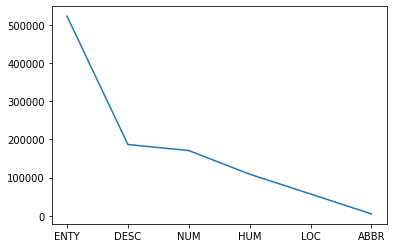

In [0]:
all_augs.labels.value_counts().plot()

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_4k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs[:500000], test_data, epochs=1)

Epoch 1: 100%|██████████| 500000/500000 [29:53<00:00, 278.71it/s, train_loss=0.29]



Losses: train - 0.3751901, test - 0.2756640
F1 test - 0.9168
ACC test - 0.9160




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35 )

Epoch 2:   0%|          | 0/4004 [00:00<?, ?it/s]


Losses: train - 0.2652430, test - 0.1999085
F1 test - 0.9400
ACC test - 0.9400


Epoch 3:   0%|          | 0/4004 [00:00<?, ?it/s]


Losses: train - 0.1767976, test - 0.1920472
F1 test - 0.9436
ACC test - 0.9440


Epoch 4:   0%|          | 0/4004 [00:00<?, ?it/s]


Losses: train - 0.1239663, test - 0.1861012
F1 test - 0.9458
ACC test - 0.9460


Epoch 5:   0%|          | 0/4004 [00:00<?, ?it/s]


Losses: train - 0.0886707, test - 0.1812152
F1 test - 0.9456
ACC test - 0.9460


Epoch 5: 100%|██████████| 4004/4004 [00:13<00:00, 286.79it/s, train_loss=0.144]



Losses: train - 0.0664064, test - 0.1820428
F1 test - 0.9376
ACC test - 0.9380
Early stopping




# 5k

In [0]:
from glob import glob 
import pandas as pd
files = glob('./Question_augmentation/TREC6_5k_bert_0.7__*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

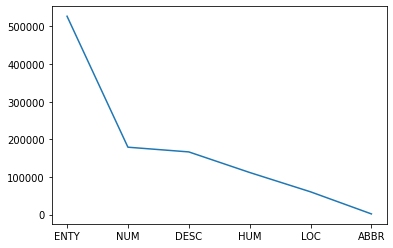

In [0]:
all_augs.labels.value_counts().plot()

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_5k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs[:500000], test_data, epochs=1)

Epoch 1: 100%|██████████| 500000/500000 [28:56<00:00, 287.90it/s, train_loss=0.288]



Losses: train - 0.3718795, test - 0.2362436
F1 test - 0.9250
ACC test - 0.9240




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35)

Epoch 2:   0%|          | 0/5006 [00:00<?, ?it/s]


Losses: train - 0.1365006, test - 0.1946371
F1 test - 0.9396
ACC test - 0.9400


Epoch 3:   0%|          | 0/5006 [00:00<?, ?it/s]


Losses: train - 0.0923348, test - 0.1893751
F1 test - 0.9397
ACC test - 0.9400


Epoch 3: 100%|██████████| 5006/5006 [00:17<00:00, 292.54it/s, train_loss=0.0988]



Losses: train - 0.0675433, test - 0.1908168
F1 test - 0.9436
ACC test - 0.9440
Early stopping




# Trec-50 bert

## 3k

In [0]:
from glob import glob 
import pandas as pd
files = glob('./Question_augmentation/TREC50_3k_bert_0.7__*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

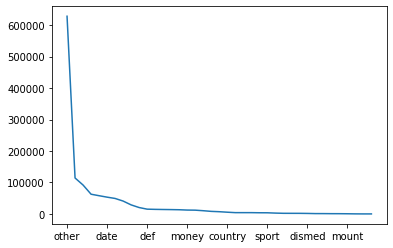

In [0]:
all_augs.labels.value_counts().plot()

In [0]:
number_of_attemp_to_fit = 1

In [0]:
train_data, test_data, l2i = read_trec50('trec50_splited/trec50_3k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs[:300000], test_data, epochs=1, out_feat=len(train_data.labels.unique()))

Epoch 1: 100%|██████████| 300000/300000 [07:21<00:00, 680.12it/s, train_loss=0.405]



Losses: train - 0.7664808, test - 1.3075326
F1 test - 0.8136
ACC test - 0.8300




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35 )

Epoch 2:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.9691845, test - 1.1830159
F1 test - 0.8297
ACC test - 0.8460


Epoch 3:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.7300985, test - 1.0644313
F1 test - 0.8255
ACC test - 0.8420


Epoch 4:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.5689557, test - 1.0021784
F1 test - 0.8257
ACC test - 0.8420


Epoch 5:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.4560271, test - 0.9403506
F1 test - 0.8269
ACC test - 0.8440


Epoch 6:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.3828230, test - 0.9169306
F1 test - 0.8222
ACC test - 0.8380


Epoch 7:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.3176113, test - 0.8728511
F1 test - 0.8319
ACC test - 0.8460


Epoch 8:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.2724996, test - 0.8574474
F1 test - 0.8247
ACC test - 0.8380


Epoch 9:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.2339724, test - 0.8253845
F1 test - 0.8279
ACC test - 0.8400


Epoch 10:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.2026925, test - 0.8046315
F1 test - 0.8277
ACC test - 0.8400


Epoch 11:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.1780109, test - 0.7975380
F1 test - 0.8246
ACC test - 0.8360


Epoch 12:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.1565911, test - 0.7711656
F1 test - 0.8283
ACC test - 0.8400


Epoch 13:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.1409176, test - 0.7522062
F1 test - 0.8273
ACC test - 0.8400


Epoch 14:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.1234313, test - 0.7463406
F1 test - 0.8224
ACC test - 0.8340


Epoch 15:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.1086316, test - 0.7275649
F1 test - 0.8257
ACC test - 0.8380


Epoch 16:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.0951286, test - 0.7090651
F1 test - 0.8271
ACC test - 0.8400


Epoch 17:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.0856081, test - 0.6958965
F1 test - 0.8344
ACC test - 0.8440


Epoch 17: 100%|██████████| 3029/3029 [00:04<00:00, 702.26it/s, train_loss=0.3]



Losses: train - 0.0746226, test - 0.7009194
F1 test - 0.8304
ACC test - 0.8380
Early stopping




## 4k

In [0]:
from glob import glob 
import pandas as pd
files = glob('./Question_augmentation/TREC50_4k_bert_0.7__*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

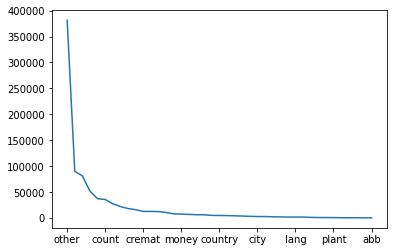

In [0]:
all_augs.labels.value_counts().plot()

In [0]:
number_of_attemp_to_fit = 1

In [0]:
train_data, test_data, l2i = read_trec50('trec50_splited/trec50_4k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs[:400000], test_data, epochs=1, out_feat=len(train_data.labels.unique()))

Epoch 1: 100%|██████████| 400000/400000 [13:04<00:00, 510.02it/s, train_loss=0.396]



Losses: train - 0.7093457, test - 1.0417978
F1 test - 0.8154
ACC test - 0.8320




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35 )

Epoch 2:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.7156377, test - 0.9191076
F1 test - 0.8257
ACC test - 0.8420


Epoch 3:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.5162005, test - 0.8534050
F1 test - 0.8392
ACC test - 0.8520


Epoch 4:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.3936978, test - 0.8260941
F1 test - 0.8430
ACC test - 0.8560


Epoch 5:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.3112526, test - 0.7953534
F1 test - 0.8465
ACC test - 0.8600


Epoch 6:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.2526069, test - 0.7859016
F1 test - 0.8483
ACC test - 0.8620


Epoch 7:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.2067956, test - 0.7634318
F1 test - 0.8472
ACC test - 0.8600


Epoch 8:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.1729514, test - 0.7473334
F1 test - 0.8575
ACC test - 0.8680


Epoch 9:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.1493632, test - 0.7397825
F1 test - 0.8525
ACC test - 0.8640


Epoch 10:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.1258764, test - 0.7254452
F1 test - 0.8562
ACC test - 0.8660


Epoch 11:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.1080787, test - 0.7219956
F1 test - 0.8586
ACC test - 0.8680


Epoch 12:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.0952072, test - 0.7166291
F1 test - 0.8565
ACC test - 0.8660


Epoch 13:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.0816557, test - 0.7085662
F1 test - 0.8538
ACC test - 0.8640


Epoch 14:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.0712747, test - 0.7037603
F1 test - 0.8585
ACC test - 0.8680


Epoch 15:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.0614916, test - 0.6964579
F1 test - 0.8601
ACC test - 0.8700


Epoch 15: 100%|██████████| 3997/3997 [00:07<00:00, 516.25it/s, train_loss=0.221]



Losses: train - 0.0548734, test - 0.6992660
F1 test - 0.8585
ACC test - 0.8680
Early stopping




## 5k

In [0]:
from glob import glob 
import pandas as pd
files = glob('./Question_augmentation/TREC50_5k_bert_0.7__*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

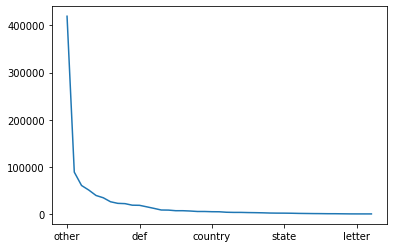

In [0]:
all_augs.labels.value_counts().plot()

In [0]:
number_of_attemp_to_fit = 1

In [0]:
train_data, test_data, l2i = read_trec50('trec50_splited/trec50_5k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs[:400000], test_data, epochs=1, out_feat=len(train_data.labels.unique()))

Epoch 1: 100%|██████████| 400000/400000 [12:19<00:00, 540.89it/s, train_loss=0.412]



Losses: train - 0.7222850, test - 0.9084116
F1 test - 0.8586
ACC test - 0.8660




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35 )

Epoch 2:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.6086937, test - 0.8365732
F1 test - 0.8616
ACC test - 0.8680


Epoch 3:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.4076982, test - 0.7947687
F1 test - 0.8628
ACC test - 0.8700


Epoch 4:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.2945391, test - 0.7717591
F1 test - 0.8683
ACC test - 0.8760


Epoch 5:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.2196459, test - 0.7553900
F1 test - 0.8622
ACC test - 0.8680


Epoch 6:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.1710429, test - 0.7400607
F1 test - 0.8638
ACC test - 0.8700


Epoch 7:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.1402434, test - 0.7317985
F1 test - 0.8622
ACC test - 0.8680


Epoch 8:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.1117345, test - 0.7286611
F1 test - 0.8622
ACC test - 0.8680


Epoch 9:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0936276, test - 0.7219244
F1 test - 0.8586
ACC test - 0.8640


Epoch 10:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0789992, test - 0.7113533
F1 test - 0.8616
ACC test - 0.8660


Epoch 11:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0667504, test - 0.7045240
F1 test - 0.8586
ACC test - 0.8640


Epoch 12:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0577923, test - 0.6999785
F1 test - 0.8578
ACC test - 0.8640


Epoch 13:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0505400, test - 0.6940719
F1 test - 0.8581
ACC test - 0.8640


Epoch 14:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0436380, test - 0.6876152
F1 test - 0.8600
ACC test - 0.8660


Epoch 15:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0378225, test - 0.6822070
F1 test - 0.8628
ACC test - 0.8700


Epoch 16:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0342816, test - 0.6764696
F1 test - 0.8596
ACC test - 0.8660


Epoch 17:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0308711, test - 0.6724404
F1 test - 0.8596
ACC test - 0.8660


Epoch 17: 100%|██████████| 5009/5009 [00:09<00:00, 542.82it/s, train_loss=0.146]



Losses: train - 0.0267780, test - 0.6772968
F1 test - 0.8638
ACC test - 0.8680
Early stopping




# Trec-6 bert faiss

## 3k

In [0]:
from glob import glob 
import pandas as pd
files = glob('./USE_filtring_3k*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_3k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs, test_data, epochs=1, out_feat=len(train_data.labels.unique()))

Epoch 1: 100%|██████████| 319823/319823 [15:54<00:00, 335.06it/s, train_loss=0.00515]



Losses: train - 0.1247567, test - 0.3220211
F1 test - 0.9065
ACC test - 0.9060




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35 )


Epoch 1: 100%|██████████| 3004/3004 [00:09<00:00, 324.46it/s, train_loss=0.324]

Epoch 2:   0%|          | 0/3004 [00:00<?, ?it/s]


Losses: train - 0.3235603, test - 0.2812827
F1 test - 0.9202
ACC test - 0.9200



Epoch 2: 100%|██████████| 3004/3004 [00:09<00:00, 331.32it/s, train_loss=0.252]

Epoch 3:   0%|          | 0/3004 [00:00<?, ?it/s]


Losses: train - 0.1798985, test - 0.2738299
F1 test - 0.9281
ACC test - 0.9280



Epoch 3: 100%|██████████| 3004/3004 [00:09<00:00, 328.59it/s, train_loss=0.204]

Epoch 4:   0%|          | 0/3004 [00:00<?, ?it/s]


Losses: train - 0.1096352, test - 0.2700460
F1 test - 0.9214
ACC test - 0.9220



Epoch 4: 100%|██████████| 3004/3004 [00:09<00:00, 329.98it/s, train_loss=0.171]

Epoch 5:   0%|          | 0/3004 [00:00<?, ?it/s]


Losses: train - 0.0691749, test - 0.2677259
F1 test - 0.9280
ACC test - 0.9280



Epoch 5: 100%|██████████| 3004/3004 [00:09<00:00, 330.27it/s, train_loss=0.147]



Losses: train - 0.0518437, test - 0.2790036
F1 test - 0.9257
ACC test - 0.9260
Early stopping




## 4k

In [0]:
!ls

In [0]:
from glob import glob 
import pandas as pd
files = glob('./USE_filtring_trec6_4*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_4k.csv')

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs, test_data, epochs=1, out_feat=len(train_data.labels.unique()))

Epoch 1: 100%|██████████| 437297/437297 [33:32<00:00, 217.26it/s, train_loss=0.0024]



Losses: train - 0.0977614, test - 0.2442475
F1 test - 0.9224
ACC test - 0.9220




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35 )

Epoch 2:   0%|          | 0/4004 [00:00<?, ?it/s]


Losses: train - 0.3610421, test - 0.2109840
F1 test - 0.9300
ACC test - 0.9300


Epoch 3:   0%|          | 0/4004 [00:00<?, ?it/s]


Losses: train - 0.1805493, test - 0.1917363
F1 test - 0.9378
ACC test - 0.9380


Epoch 3: 100%|██████████| 4004/4004 [00:19<00:00, 200.88it/s, train_loss=0.214]



Losses: train - 0.0997950, test - 0.1933684
F1 test - 0.9358
ACC test - 0.9360
Early stopping




In [0]:
from glob import glob 
import pandas as pd
files = glob('./USE_filtring_trec6_5*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

In [0]:
train_data, test_data, l2i = read_trec6('trec6_splited/trec6_splited_5k.csv')

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs, test_data, epochs=1, out_feat=len(train_data.labels.unique()))

Epoch 1: 100%|██████████| 531763/531763 [48:14<00:00, 183.71it/s, train_loss=0.0019]



Losses: train - 0.0882109, test - 0.2574628
F1 test - 0.9319
ACC test - 0.9320




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35 )

Epoch 2:   0%|          | 0/5006 [00:00<?, ?it/s]


Losses: train - 0.3718233, test - 0.2278614
F1 test - 0.9400
ACC test - 0.9400


Epoch 3:   0%|          | 0/5006 [00:00<?, ?it/s]


Losses: train - 0.1832943, test - 0.2196328
F1 test - 0.9436
ACC test - 0.9440


Epoch 3:  36%|███▌      | 1792/5006 [00:09<00:15, 205.52it/s, train_loss=0.247]

# Trec-50 bert faiss

## 3k

In [0]:
from glob import glob 
import pandas as pd
files = glob('./USE_filtring_trec50_3k_*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

In [0]:
train_data, test_data, l2i = read_trec50('trec50_splited/trec50_3k.csv')

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs, test_data, epochs=1, out_feat=len(train_data.labels.unique()))

Epoch 1: 100%|██████████| 383185/383185 [20:59<00:00, 304.16it/s, train_loss=0.00225]



Losses: train - 0.3134682, test - 1.4217985
F1 test - 0.8259
ACC test - 0.8380




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35 )

Epoch 2:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 1.0994483, test - 1.3606861
F1 test - 0.8394
ACC test - 0.8440


Epoch 3:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.7938955, test - 1.2192850
F1 test - 0.8351
ACC test - 0.8440


Epoch 4:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.5882109, test - 1.1218241
F1 test - 0.8365
ACC test - 0.8460


Epoch 5:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.4490861, test - 1.0452914
F1 test - 0.8364
ACC test - 0.8460


Epoch 6:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.3501996, test - 0.9789737
F1 test - 0.8382
ACC test - 0.8480


Epoch 7:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.2827247, test - 0.9221051
F1 test - 0.8449
ACC test - 0.8560


Epoch 8:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.2382966, test - 0.8960834
F1 test - 0.8412
ACC test - 0.8520


Epoch 9:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.1985323, test - 0.8572948
F1 test - 0.8414
ACC test - 0.8520


Epoch 10:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.1671511, test - 0.8261130
F1 test - 0.8427
ACC test - 0.8540


Epoch 11:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.1461159, test - 0.8103666
F1 test - 0.8421
ACC test - 0.8540


Epoch 12:   0%|          | 0/3029 [00:00<?, ?it/s]


Losses: train - 0.1276550, test - 0.7759590
F1 test - 0.8421
ACC test - 0.8540


Epoch 12: 100%|██████████| 3029/3029 [00:09<00:00, 328.91it/s, train_loss=0.38]



Losses: train - 0.1141298, test - 0.7808569
F1 test - 0.8423
ACC test - 0.8540
Early stopping




## 4k

In [0]:
from glob import glob 
import pandas as pd
files = glob('./USE_filtring_trec50_4k_*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

In [0]:
train_data, test_data, l2i = read_trec50('trec50_splited/trec50_4k.csv')

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs, test_data, epochs=1, out_feat=len(train_data.labels.unique()))

Epoch 1: 100%|██████████| 365148/365148 [25:50<00:00, 235.51it/s, train_loss=0.00772]



Losses: train - 0.3522405, test - 1.1417055
F1 test - 0.8465
ACC test - 0.8540




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35 )

Epoch 2:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.8679078, test - 1.0338309
F1 test - 0.8432
ACC test - 0.8480


Epoch 3:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.5637486, test - 0.9476960
F1 test - 0.8537
ACC test - 0.8560


Epoch 4:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.3950760, test - 0.9071976
F1 test - 0.8604
ACC test - 0.8640


Epoch 5:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.2834256, test - 0.8677795
F1 test - 0.8597
ACC test - 0.8640


Epoch 6:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.2154012, test - 0.8382729
F1 test - 0.8574
ACC test - 0.8620


Epoch 7:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.1723569, test - 0.8074419
F1 test - 0.8537
ACC test - 0.8580


Epoch 8:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.1416812, test - 0.7855943
F1 test - 0.8594
ACC test - 0.8640


Epoch 9:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.1166887, test - 0.7806336
F1 test - 0.8503
ACC test - 0.8560


Epoch 10:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.0968025, test - 0.7671749
F1 test - 0.8485
ACC test - 0.8540


Epoch 11:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.0838667, test - 0.7561043
F1 test - 0.8498
ACC test - 0.8560


Epoch 12:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.0720772, test - 0.7463083
F1 test - 0.8435
ACC test - 0.8500


Epoch 13:   0%|          | 0/3997 [00:00<?, ?it/s]


Losses: train - 0.0626004, test - 0.7411050
F1 test - 0.8464
ACC test - 0.8540


Epoch 13: 100%|██████████| 3997/3997 [00:17<00:00, 223.01it/s, train_loss=0.24]



Losses: train - 0.0533004, test - 0.7444521
F1 test - 0.8467
ACC test - 0.8540
Early stopping




## 5k

In [0]:
from glob import glob 
import pandas as pd
files = glob('./USE_filtring_trec50_5k_*')
all_augs = pd.concat([pd.read_csv(i, index_col=0) for i in files])

In [0]:
train_data, test_data, l2i = read_trec50('trec50_splited/trec50_5k.csv')

In [0]:
f1_scor, acc_scor, model_aug_mlp, tf = re_FIT_base_MLP(all_augs, test_data, epochs=1, out_feat=len(train_data.labels.unique()))

Epoch 1: 100%|██████████| 472135/472135 [35:45<00:00, 220.10it/s, train_loss=0.00322]



Losses: train - 0.2838174, test - 1.0994843
F1 test - 0.8541
ACC test - 0.8640




In [0]:
a, b, c, f = re_FIT_base_MLP(train_data, test_data, model_aug_mlp, tf, epochs=35)

Epoch 2:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.7704405, test - 0.9774989
F1 test - 0.8592
ACC test - 0.8640


Epoch 3:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.4610392, test - 0.9159688
F1 test - 0.8670
ACC test - 0.8740


Epoch 4:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.3046430, test - 0.8831213
F1 test - 0.8625
ACC test - 0.8680


Epoch 5:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.2107088, test - 0.8442900
F1 test - 0.8631
ACC test - 0.8680


Epoch 6:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.1582718, test - 0.8123216
F1 test - 0.8587
ACC test - 0.8640


Epoch 7:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.1234274, test - 0.7917598
F1 test - 0.8608
ACC test - 0.8660


Epoch 8:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.1003100, test - 0.7719723
F1 test - 0.8561
ACC test - 0.8620


Epoch 9:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0804216, test - 0.7714705
F1 test - 0.8553
ACC test - 0.8600


Epoch 10:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0662274, test - 0.7428123
F1 test - 0.8554
ACC test - 0.8600


Epoch 11:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0563558, test - 0.7322334
F1 test - 0.8568
ACC test - 0.8620


Epoch 12:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0485496, test - 0.7166423
F1 test - 0.8558
ACC test - 0.8600


Epoch 13:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0420597, test - 0.7145860
F1 test - 0.8603
ACC test - 0.8620


Epoch 14:   0%|          | 0/5009 [00:00<?, ?it/s]


Losses: train - 0.0399785, test - 0.7038598
F1 test - 0.8620
ACC test - 0.8640


Epoch 14: 100%|██████████| 5009/5009 [00:23<00:00, 208.98it/s, train_loss=0.178]



Losses: train - 0.0345182, test - 0.7053163
F1 test - 0.8566
ACC test - 0.8580
Early stopping


